# Figure 5:  Clonal gene expression in mouse brains

Here we examine data from Michael Ratz, Leonie von Berlin, and others (?), relating to gene expression in mouse brain cells.  Cells were barcoded and then developed into various kinds of brain cells.  Later, the clones were identified by barcode, and we examine the gene expression profile of various clones and cell types.

We begin by loading packages we'll need.

In [14]:
import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
import statsmodels.api as sm

from IPython.display import display # Pretty display of data frames.

# Import various functions for stats.
import scipy.stats as ss
from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
from scipy.stats import kurtosis, skew, zscore # For detecting bimodality
import scipy.cluster.hierarchy as sch # For hierarchical clustering.

from statsmodels.formula.api import ols

from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn import base
from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.manifold import TSNE

# Put plots inline rather than in a pop-up.
%matplotlib inline

# Loading data

## Loading single cell metadata

We load metadata on the single cells first.  The relevant cell type data is in the column CellTypes_Level4, which we rename cell_type.  The clonal information is in the column called cloneID.

In [2]:
meta_df = pd.read_csv('meta_clones.txt', sep=';')
meta_df.cloneID = meta_df.cloneID.astype(str)
meta_df.rename(columns={'CellTypes_Level4':'cell_type'}, inplace=True)
meta_df.head()

orig.ident  nCount_RNA  nFeature_RNA  region  \
10x52_AAACCCAGTAGCCAGA      10x52        3563          1766  cortex   
10x52_AAACGCTAGCATGATA      10x52        4236          1999  cortex   
10x52_AAAGAACGTGCCGAAA      10x52        3054          1513  cortex   
10x52_AAAGGATCAATTCTTC      10x52        2191          1330  cortex   
10x52_AAAGGGCAGTATTGCC      10x52        3272          1674  cortex   

                        percent.mito      Igf2       Pf4      Hexb     Rsph1  \
10x52_AAACCCAGTAGCCAGA      0.047297 -0.075548 -0.067574  1.280158 -0.181806   
10x52_AAACGCTAGCATGATA      0.036109 -0.075548 -0.067574  1.382241 -0.181806   
10x52_AAAGAACGTGCCGAAA      0.049970 -0.075548 -0.067574  1.659102 -0.181806   
10x52_AAAGGATCAATTCTTC      0.028724 -0.075548 -0.067574  1.572128 -0.181806   
10x52_AAAGGGCAGTATTGCC      0.115278 -0.075548 -0.067574  1.415809 -0.181806   

                          Pdgfra  ...  RNA_snn_res.0.7  RNA_snn_res.0.8  \
10x52_AAACCCAGTAGCCAGA -0.305591  ...                1                1   
10x52_AAACGCTAGCATGATA -0.305591  ...                1                1   
10x52_AAAGAACGTGCCGAAA -0.305591  ...                1                1   
10x52_AAAGGATCAATTCTTC -0.305591  ...                1                1   
10x52_AAAGGGCAGTATTGCC -0.305591  ...                1                1   

                        RNA_snn_res.0.9  RNA_snn_res.1  CellTypes_Level1  \
10x52_AAACCCAGTAGCCAGA                1              1            Immune   
10x52_AAACGCTAGCATGATA                1              1            Immune   
10x52_AAAGAACGTGCCGAAA                1              1            Immune   
10x52_AAAGGATCAATTCTTC                1              1            Immune   
10x52_AAAGGGCAGTATTGCC                1              1            Immune   

                        replicate  CellTypes_Level2  CellTypes_Level3  \
10x52_AAACCCAGTAGCCAGA       rep3            Immune         Microglia   
10x52_AAACGCTAGCATGATA       rep3            Immune         Microglia   
10x52_AAAGAACGTGCCGAAA       rep3            Immune         Microglia   
10x52_AAAGGATCAATTCTTC       rep3            Immune         Microglia   
10x52_AAAGGGCAGTATTGCC       rep3            Immune         Microglia   

                        cell_type  cloneID  
10x52_AAACCCAGTAGCCAGA         MG        1  
10x52_AAACGCTAGCATGATA         MG        2  
10x52_AAAGAACGTGCCGAAA         MG        2  
10x52_AAAGGATCAATTCTTC         MG        5  
10x52_AAAGGGCAGTATTGCC         MG        6  

[5 rows x 44 columns]

In [3]:
cells = list(meta_df.index)
cell_types = meta_df.cell_type.unique()
print('The metadata contains {} cells.'.format(len(cells)))
print('These belong to {} types: {}.'.format(len(cell_types), ', '.join(cell_types)))

The metadata contains 8843 cells.
These belong to 21 types: MG, PVM, GMA, RGSZ, WMA, EPEN, RGDG, OPC, COP, NFOL, MFOL, MOL, TEGLU, nIPC, OBNBL, CR, TEINH, OBINH, DGNBL, MSN, DGGRC.


Later, we might focus on the six cell types below.  Microglia (MG) are very different from the others.  Also, TEGLU might really be subdivided into subtypes, so we expect more variation within TEGLU cells.

In [4]:
cell_types_focus = ['OBNBL', 'DGNBL', 'GMA', 'WMA', 'OPC', 'COP']

In [5]:
reps = meta_df.replicate.unique()
print('The cells belong to {} replicates: {}.'.format(len(reps), ', '.join(reps)))

The cells belong to 2 replicates: rep3, rep4.


Here, "rep3" and "rep4" are really two different brains.

In [6]:
regions = meta_df.region.unique()
print('The cells belong to {} regions: {}.'.format(len(regions), ', '.join(regions)))

The cells belong to 3 regions: cortex, striatum, hippocampus.


In [7]:
clones = meta_df.cloneID.unique()
clone_pops = meta_df.cloneID.value_counts()
big_clones = list(clone_pops[clone_pops >= 12].index)
print('The cells belong to {} clones. \n'
      'The {} clones with at least 12 cells are:  {}.'.format(len(clones), len(big_clones), ', '.join(big_clones)))

The cells belong to 1809 clones. 
The 107 clones with at least 12 cells are:  10, 19, 1, 15, 5, 2, 7, 42, 12, 22, 13, 1048, 30, 6, 340, 1097, 1038, 1065, 1032, 765, 623, 1040, 1071, 1179, 1036, 1128, 1199, 1155, 1093, 1096, 476, 23, 14, 1516, 159, 1020, 1203, 1087, 105, 487, 1044, 1120, 1079, 41, 1125, 1147, 1223, 784, 906, 944, 1154, 1232, 1070, 49, 1206, 945, 339, 1035, 1107, 1069, 1137, 716, 482, 45, 722, 575, 311, 1188, 1209, 1088, 236, 1041, 1146, 1090, 1162, 483, 1136, 62, 1157, 811, 1132, 554, 348, 1142, 351, 1100, 751, 1026, 1408, 693, 1269, 620, 1197, 511, 1122, 983, 1389, 1252, 1589, 1175, 1158, 730, 1205, 1106, 517, 1404, 322.


Clonal information is earlier in development -- a single clone may develop into various cell types.  To see the possibilities, we map out the populations within each clone/celltype with some clustering.  We focus on the clones with at least 12 cells for simplicity.

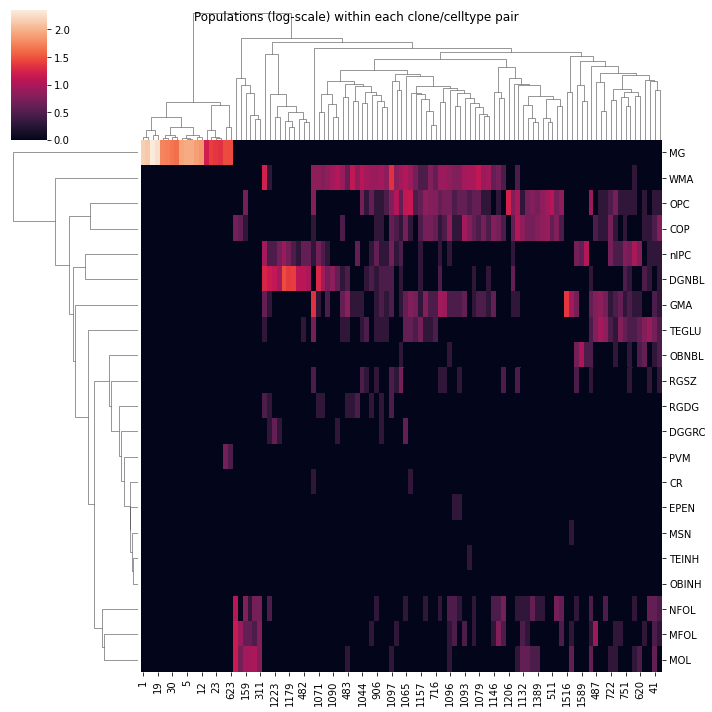

In [8]:
pop_df = pd.DataFrame(0, index = big_clones, columns = cell_types)
for cl in big_clones:
    for ct in cell_types:
        pop_df.loc[cl,ct] = len(meta_df[ (meta_df.cloneID == cl) & (meta_df.cell_type == ct)])
sns.clustermap(np.log10(pop_df+1).T)
plt.suptitle('Populations (log-scale) within each clone/celltype pair')
plt.show()

Above we see that clones that end up as Microglia (MG) do not also contain other cell types.  But clones often end up in the MOL/MFOL/NFOL category interchangeably.  Similarly with WMA/OPC/COP and nIPC/DGNBL.

## Loading the expression matrix

Now we load the gene expression matrix.  There are two such matrices -- one with raw counts, and one more processed version.

In [15]:
data_df = pd.read_csv('data_clones.txt', sep=';')
data_df.head()

X10x52_AAACCCAGTAGCCAGA  X10x52_AAACGCTAGCATGATA  \
Xkr4                   0.000000                      0.0   
Sox17                  0.000000                      0.0   
Mrpl15                 0.000000                      0.0   
Lypla1                 1.336743                      0.0   
Tcea1                  0.000000                      0.0   

        X10x52_AAAGAACGTGCCGAAA  X10x52_AAAGGATCAATTCTTC  \
Xkr4                        0.0                      0.0   
Sox17                       0.0                      0.0   
Mrpl15                      0.0                      0.0   
Lypla1                      0.0                      0.0   
Tcea1                       0.0                      0.0   

        X10x52_AAAGGGCAGTATTGCC  X10x52_AAAGGGCGTCAACCTA  \
Xkr4                        0.0                      0.0   
Sox17                       0.0                      0.0   
Mrpl15                      0.0                      0.0   
Lypla1                      0.0                      0.0   
Tcea1                       0.0                      0.0   

        X10x52_AAAGGTAAGACTCCGC  X10x52_AAAGGTACAAATACGA  \
Xkr4                   0.000000                 0.000000   
Sox17                  0.000000                 0.000000   
Mrpl15                 1.302394                 0.000000   
Lypla1                 0.000000                 1.070365   
Tcea1                  1.302394                 0.000000   

        X10x52_AAAGTGACAGCAATTC  X10x52_AAAGTGATCCAGTGCG  ...  \
Xkr4                        0.0                 0.000000  ...   
Sox17                       0.0                 0.000000  ...   
Mrpl15                      0.0                 0.000000  ...   
Lypla1                      0.0                 0.000000  ...   
Tcea1                       0.0                 2.003697  ...   

        X10x67_TTGTTTGTCAAGTGGG  X10x67_TTTACGTAGTGCACCC  \
Xkr4                   0.000000                      0.0   
Sox17                  0.000000                      0.0   
Mrpl15                 0.000000                      0.0   
Lypla1                 0.000000                      0.0   
Tcea1                  1.247962                      0.0   

        X10x67_TTTACGTCAGATCCTA  X10x67_TTTATGCGTTGAGAGC  \
Xkr4                        0.0                 0.000000   
Sox17                       0.0                 0.000000   
Mrpl15                      0.0                 1.898666   
Lypla1                      0.0                 0.000000   
Tcea1                       0.0                 0.000000   

        X10x67_TTTCATGCAGAGTGTG  X10x67_TTTCATGGTCGTGCCA  \
Xkr4                        0.0                 1.276474   
Sox17                       0.0                 0.000000   
Mrpl15                      0.0                 0.000000   
Lypla1                      0.0                 0.000000   
Tcea1                       0.0                 0.000000   

        X10x67_TTTCCTCTCCCAGTGG  X10x67_TTTGGAGAGCCAACCC  \
Xkr4                    0.00000                 0.000000   
Sox17                   0.00000                 0.000000   
Mrpl15                  0.64819                 1.167794   
Lypla1                  0.64819                 0.000000   
Tcea1                   0.00000                 0.906885   

        X10x67_TTTGGTTGTACTGTTG  X10x67_TTTGTTGCAGTAGATA  
Xkr4                        0.0                      0.0  
Sox17                       0.0                      0.0  
Mrpl15                      0.0                      0.0  
Lypla1                      0.0                      0.0  
Tcea1                       0.0                      0.0  

[5 rows x 8843 columns]

We delete the "X" from the beginning of each cell name, so it matches the metadata.

In [16]:
data_df.columns = [col[1:] for col in data_df.columns]
data_df.head()

10x52_AAACCCAGTAGCCAGA  10x52_AAACGCTAGCATGATA  \
Xkr4                  0.000000                     0.0   
Sox17                 0.000000                     0.0   
Mrpl15                0.000000                     0.0   
Lypla1                1.336743                     0.0   
Tcea1                 0.000000                     0.0   

        10x52_AAAGAACGTGCCGAAA  10x52_AAAGGATCAATTCTTC  \
Xkr4                       0.0                     0.0   
Sox17                      0.0                     0.0   
Mrpl15                     0.0                     0.0   
Lypla1                     0.0                     0.0   
Tcea1                      0.0                     0.0   

        10x52_AAAGGGCAGTATTGCC  10x52_AAAGGGCGTCAACCTA  \
Xkr4                       0.0                     0.0   
Sox17                      0.0                     0.0   
Mrpl15                     0.0                     0.0   
Lypla1                     0.0                     0.0   
Tcea1                      0.0                     0.0   

        10x52_AAAGGTAAGACTCCGC  10x52_AAAGGTACAAATACGA  \
Xkr4                  0.000000                0.000000   
Sox17                 0.000000                0.000000   
Mrpl15                1.302394                0.000000   
Lypla1                0.000000                1.070365   
Tcea1                 1.302394                0.000000   

        10x52_AAAGTGACAGCAATTC  10x52_AAAGTGATCCAGTGCG  ...  \
Xkr4                       0.0                0.000000  ...   
Sox17                      0.0                0.000000  ...   
Mrpl15                     0.0                0.000000  ...   
Lypla1                     0.0                0.000000  ...   
Tcea1                      0.0                2.003697  ...   

        10x67_TTGTTTGTCAAGTGGG  10x67_TTTACGTAGTGCACCC  \
Xkr4                  0.000000                     0.0   
Sox17                 0.000000                     0.0   
Mrpl15                0.000000                     0.0   
Lypla1                0.000000                     0.0   
Tcea1                 1.247962                     0.0   

        10x67_TTTACGTCAGATCCTA  10x67_TTTATGCGTTGAGAGC  \
Xkr4                       0.0                0.000000   
Sox17                      0.0                0.000000   
Mrpl15                     0.0                1.898666   
Lypla1                     0.0                0.000000   
Tcea1                      0.0                0.000000   

        10x67_TTTCATGCAGAGTGTG  10x67_TTTCATGGTCGTGCCA  \
Xkr4                       0.0                1.276474   
Sox17                      0.0                0.000000   
Mrpl15                     0.0                0.000000   
Lypla1                     0.0                0.000000   
Tcea1                      0.0                0.000000   

        10x67_TTTCCTCTCCCAGTGG  10x67_TTTGGAGAGCCAACCC  \
Xkr4                   0.00000                0.000000   
Sox17                  0.00000                0.000000   
Mrpl15                 0.64819                1.167794   
Lypla1                 0.64819                0.000000   
Tcea1                  0.00000                0.906885   

        10x67_TTTGGTTGTACTGTTG  10x67_TTTGTTGCAGTAGATA  
Xkr4                       0.0                     0.0  
Sox17                      0.0                     0.0  
Mrpl15                     0.0                     0.0  
Lypla1                     0.0                     0.0  
Tcea1                      0.0                     0.0  

[5 rows x 8843 columns]

In [17]:
print('Expression matrix loaded for {} cells and {} genes.'.format(data_df.shape[1], data_df.shape[0]))

Expression matrix loaded for 8843 cells and 18587 genes.


In [18]:
data_df = data_df.T # I prefer the columns to be genes.
data_df.head()

Xkr4  Sox17  Mrpl15    Lypla1  Tcea1  Rgs20   Atp6v1h  \
10x52_AAACCCAGTAGCCAGA   0.0    0.0     0.0  1.336743    0.0    0.0  1.336743   
10x52_AAACGCTAGCATGATA   0.0    0.0     0.0  0.000000    0.0    0.0  0.000000   
10x52_AAAGAACGTGCCGAAA   0.0    0.0     0.0  0.000000    0.0    0.0  0.000000   
10x52_AAAGGATCAATTCTTC   0.0    0.0     0.0  0.000000    0.0    0.0  0.000000   
10x52_AAAGGGCAGTATTGCC   0.0    0.0     0.0  0.000000    0.0    0.0  0.000000   

                        Oprk1  Npbwr1  Rb1cc1  ...  Hist1h3h  Hist1h4n  \
10x52_AAACCCAGTAGCCAGA    0.0     0.0     0.0  ...       0.0       0.0   
10x52_AAACGCTAGCATGATA    0.0     0.0     0.0  ...       0.0       0.0   
10x52_AAAGAACGTGCCGAAA    0.0     0.0     0.0  ...       0.0       0.0   
10x52_AAAGGATCAATTCTTC    0.0     0.0     0.0  ...       0.0       0.0   
10x52_AAAGGGCAGTATTGCC    0.0     0.0     0.0  ...       0.0       0.0   

                        Hist1h2ah  1700066J03Rik  4933425L06Rik  Rtl1  \
10x52_AAACCCAGTAGCCAGA        0.0            0.0            0.0   0.0   
10x52_AAACGCTAGCATGATA        0.0            0.0            0.0   0.0   
10x52_AAAGAACGTGCCGAAA        0.0            0.0            0.0   0.0   
10x52_AAAGGATCAATTCTTC        0.0            0.0            0.0   0.0   
10x52_AAAGGGCAGTATTGCC        0.0            0.0            0.0   0.0   

                        Gm17111  Gm10505  H2-Q1  I830134H01Rik  
10x52_AAACCCAGTAGCCAGA      0.0      0.0    0.0            0.0  
10x52_AAACGCTAGCATGATA      0.0      0.0    0.0            0.0  
10x52_AAAGAACGTGCCGAAA      0.0      0.0    0.0            0.0  
10x52_AAAGGATCAATTCTTC      0.0      0.0    0.0            0.0  
10x52_AAAGGGCAGTATTGCC      0.0      0.0    0.0            0.0  

[5 rows x 18587 columns]

We look at the number of genes expressed, and the average nonzero expression, by cell type.  This is a step for quality control, and just to look for general differences between cell types.  We divide things by replicate too, as a second quality check.

In [19]:
no_genes = (data_df > 0.1).sum(axis=1)

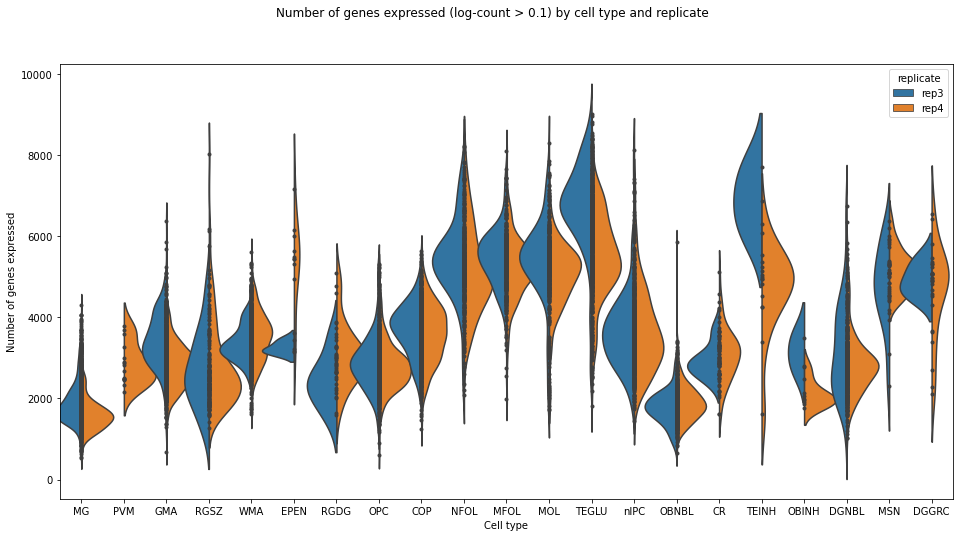

In [22]:
fig,ax = plt.subplots(figsize = (16,8))
sns.violinplot(x = meta_df.cell_type, y = no_genes, hue=meta_df.replicate, ax=ax, width=1.5, inner='point', split=True)
plt.suptitle('Number of genes expressed (log-count > 0.1) by cell type and replicate')
ax.set_ylabel('Number of genes expressed')
ax.set_xlabel('Cell type')
plt.show()

In [23]:
ave_nz_genes = data_df[data_df > 0.1].mean(axis=1)

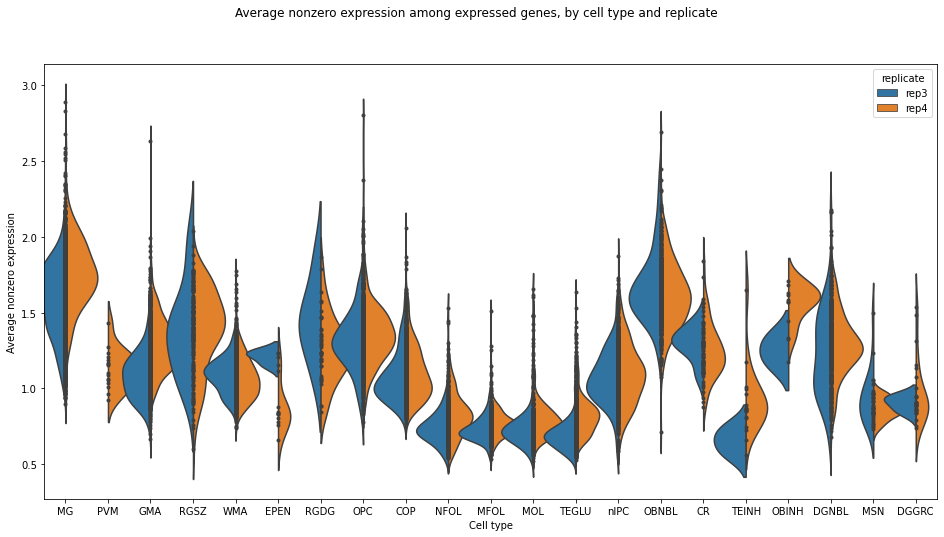

In [24]:
fig,ax = plt.subplots(figsize = (16,8))
sns.violinplot(x = meta_df.cell_type, y = ave_nz_genes, inner='point', hue=meta_df.replicate, 
               width=1.5, split=True, ax=ax)
plt.suptitle('Average nonzero expression among expressed genes, by cell type and replicate')
ax.set_ylabel('Average nonzero expression')
ax.set_xlabel('Cell type')
plt.show()

There are a few cell types where there might be divergences between the two brains (rep3 and rep4).  Eyeballing it, these are EPEN, TEINH, and OBINH.  But these just have a small number of cells in each.

In [26]:
for ct in ['EPEN','TEINH','OBINH']:
    print('There are {} cells of type {}.'.format(len(meta_df[meta_df['cell_type'] == ct]), ct))

There are 14 cells of type EPEN.
There are 18 cells of type TEINH.
There are 11 cells of type OBINH.


# Machine learning experiment

As an experiment, we see if a standard machine learning approach (LinearSVM) can predict clonality from gene expression.  For this, we create some balanced test data.  We begin with cell types in which there are at least 8 clones with at least 5 cells each. We use these to create balanced samples later.

In [9]:
meta_by_type = {}
for ct in cell_types:
    data = meta_df[meta_df['cell_type'] == ct]
    cp = data.cloneID.value_counts()
    if len(cp) >= 8:
        if cp[7] >= 5:
            data = data[data.cloneID.isin(cp[:8].index)]
            meta_by_type[ct] = data

for ct in meta_by_type.keys():
    print('The at-least-5-cell clones of cell type {} are: {}.'.format(ct, ', '.join(meta_by_type[ct].cloneID.unique()) ))

The at-least-5-cell clones of cell type MG are: 1, 2, 5, 7, 10, 15, 19, 42.
The at-least-5-cell clones of cell type GMA are: 49, 351, 483, 1038, 1155, 1020, 1423, 1516.
The at-least-5-cell clones of cell type WMA are: 1041, 1044, 1065, 1079, 1097, 1125, 1136, 1048.
The at-least-5-cell clones of cell type OPC are: 511, 1040, 1065, 1137, 1206, 1128, 1167, 1203.
The at-least-5-cell clones of cell type COP are: 615, 1076, 1128, 1132, 1137, 1093, 1197, 1096.
The at-least-5-cell clones of cell type MOL are: 52, 31, 322, 340, 349, 159, 311, 1035.
The at-least-5-cell clones of cell type TEGLU are: 49, 62, 479, 546, 551, 575, 563, 697.
The at-least-5-cell clones of cell type nIPC are: 373, 1032, 1048, 1404, 945, 1436, 1448, 1646.
The at-least-5-cell clones of cell type OBNBL are: 335, 1418, 1566, 1578, 1589, 1414, 1678, 1665.
The at-least-5-cell clones of cell type DGNBL are: 476, 1036, 1032, 1048, 1071, 1179, 1205, 1223.


Now we randomly downsample within each cell type, so that the eight biggest clones have the same population.  The following is a general-purpose function to randomly downsample a dataframe, so that the value-counts of one column (down_col) are all the same.

In [10]:
def down_sample(df, down_col):
    samples = df.index
    df_pops = df[down_col].value_counts()
    minpop = df_pops.min()
    df_list = []
    for cl in df[down_col].unique():
        if df_pops[cl] >= minpop:
            df_list.append(df[df[down_col] == cl].sample(minpop))
    return pd.concat(df_list)

Now we randomly downsample.

In [13]:
cells_by_type = {}
by_types = list(meta_by_type.keys())

for ct in meta_by_type.keys():
    meta_by_type[ct] = down_sample(meta_by_type[ct], 'cloneID')
    cells_by_type[ct] = list(meta_by_type[ct].index)
    
for ct in by_types:
    print('Eight clones with {} cells each created for cell type {}'.format(
        meta_by_type[ct].cloneID.value_counts().min(),ct))

Eight clones with 77 cells each created for cell type MG
Eight clones with 6 cells each created for cell type GMA
Eight clones with 9 cells each created for cell type WMA
Eight clones with 8 cells each created for cell type OPC
Eight clones with 5 cells each created for cell type COP
Eight clones with 5 cells each created for cell type MOL
Eight clones with 5 cells each created for cell type TEGLU
Eight clones with 5 cells each created for cell type nIPC
Eight clones with 5 cells each created for cell type OBNBL
Eight clones with 11 cells each created for cell type DGNBL


Now we take a quick look to see if a LinearSVM can predict clonality from gene expression.  First we provide two general-purpose functions for visualizing the cross-validation and predictive accuracy.

In [27]:
def CV_map(gs, swap=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))

def confusion_matrix(X,y,pipe, reps=2, classlist = None):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    valid = counts.apply(lambda column : column/cpops['pop']) #['pop'] )
    
    f, ax = plt.subplots(figsize=(8,7))
    sns.heatmap(valid, annot=valid, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.046, 'pad':0.04}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, .5, .75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_ylabel("Actual class")
    ax.set_xlabel("Predicted class")
    ax.set_title("Overall prediction accuracy {:0.3%}. \n"
                 "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))


Next is a general-purpose function for displaying heatmaps of gene expression.

In [91]:
def vis_genebars(ef, mf, genelist, prop, prop_sec = None, classlist = None, style='z_score', 
                 cutoff = 1.0, genelabels = True, samplelabels=False, 
                 fitlabels = False, gene_cluster=True, gene_marker=False, sort_samples = True, titleline=None,
                 gene_names = None, savefig = None, savetype='.pdf', labelift=0.0, fig_width=12):
    '''
    Visualizes gene expression across cells.
    
    Args:
        ef (pandas dataframe):  The gene expression matrix.
        mf (pandas dataframe:  The metadata dataframe.
        genelist (list): The list of genes to visualize.
        prop:  A column of the metadata, e.g. Clone_ID.  Place cells in blocks according to this.
        classlist:  Custom sort Clone_ID (or whatever prop) according to this list.
        z_score:  Plot z-scores for each gene.
        binarize:  Plot binarized data, e.g. whether a gene is on or off.
        cutoff:  The cutoff for binarization.
        genelabels:  Label the rows by genes if True.
        fitlabels:  If True, extend the height of the image to fit in all the gene labels.
        
    Returns:
        None.  Just makes a pretty picture.
        
    
    '''
    genelist = [gene for gene in genelist if gene in ef.columns]
    df = ef[genelist].copy()
    genelist = [gene.split('!')[0] for gene in genelist]
    df.columns = genelist
    if type(mf) == pd.DataFrame:
        df[prop] = mf[prop]
    else:
        df[prop] = mf
    if sort_samples:
        if classlist is None:
            df.sort_values(prop, inplace=True)
        else:
            df = sort_by(df, prop, classlist)
    
    cells = df.index
    md = mf.loc[cells]
    classes = df[prop].unique()
    
    if gene_marker:
        marker_list = []
        class_aves = df.groupby(prop).mean()
        class_maxes = class_aves.idxmax(axis=0)
        for cl in classes:
            marker_list += [gene for gene in genelist if class_maxes[gene] == cl ]
        genelist = marker_list
    
    if prop_sec:
        df[prop_sec] = mf[prop_sec]
        classes_sec = md[prop_sec].unique()
        
    # Create plot.
    
    # Adjust height to include labels.
    if fitlabels:
        figheight = len(genelist) // 4
    else:
        figheight = 12
    figsize=(fig_width, figheight)
    
    # Create colors for clones (or whatever classes)
    pal = sns.cubehelix_palette(len(classes),light=.9, dark=.1, reverse=True, start=1, rot=-2)
    lut = dict(zip(classes, pal))
    colors = pd.Series(df[prop]).map(lut)
    
    if prop_sec:
        # Create colors for secondary classes.
        pal_sec = sns.cubehelix_palette(len(classes_sec),light=.9, dark=.1, reverse=False, start=1, rot=-2)
        lut_sec = dict(zip(classes_sec, pal_sec))
        colors_sec = pd.Series(df[prop_sec]).map(lut_sec)
        colors = [colors, colors_sec]
        
    #genepal = sns.cubehelix_palette(len(pathways),light=.9, dark=.1, reverse=True, start=1, rot=-2)
    #genelut = dict(zip(pathways, genepal))
    #genecolors = gene_labels[genelist].map(genelut)
    
    if titleline:
        title = [titleline]
    else:
        title = []
    title.append('Expression for {} genes.'.format(len(genelist)))
    
    if style == 'z_score':
        method,metric = 'average', 'cosine'
        cg = sns.clustermap(df[genelist].transpose(), z_score=0, cmap="bwr", vmin=-3, vmax=3, 
                            col_colors=colors, figsize=figsize, col_cluster=False, 
                            row_cluster=gene_cluster, metric=metric, method=method)
        title.append('Color represents z-score.')
    
    elif style == 'absolute':
        method,metric = 'average', 'euclidean'
        cg = sns.clustermap(df[genelist].transpose(), standard_scale=0, cmap="cool", vmin=0, vmax=1,
                            col_colors=colors, figsize=figsize, col_cluster=False, row_cluster=gene_cluster,
                           metric=metric, method=method)
        title.append('Color represents log-normed gene expression.')
        
    elif style == 'binarize':
        method,metric = 'complete', 'hamming'
        cg = sns.clustermap(df[genelist].transpose() > cutoff, cmap="magma", vmin=0, vmax=1.0, 
                            col_colors=colors, figsize=figsize, col_cluster=False, row_cluster=gene_cluster,
                            metric = metric, method=method)
        title.append('Binarized gene expression')
        
    figtitle = '\n '.join(title)
    
    cg.ax_row_dendrogram.set_visible(False)
    #cg.ax_col_dendrogram.set_visible(False)
    if style == 'z_score':
        cg.cax.set_position([1.05, .3, .03, .2])
    elif style == 'binarize':
        cg.cax.set_visible(False)
    ax = cg.ax_heatmap
    if not genelabels:
        ax.set_yticks([])
        ax.set_ylabel('')
        ax.set_yticklabels([])
    if not samplelabels:
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.set_xticklabels([])
    #cg.ax_col_colors.set_title(figtitle, fontsize=14)
    #cg.ax_col_dendrogram.set_title(figtitle, fontsize=14)
    cg.ax_col_colors.set_title(figtitle, fontsize=14)
    
    j = 0
    for label in classes:
        cg.ax_col_dendrogram.bar(0, 0, color=lut[label],
                                 label=label, linewidth=0)
        no_label = len(df[df[prop] == label])
        if np.mean(lut[label]) < 0.5:
            textcolor = (1,0.8,0.8)
        else:
            textcolor = (0,0,0)
        j += no_label / 2
        cg.ax_col_colors.text(j,0.75+labelift,label, color=textcolor, ha='center', fontsize=16)
        j += no_label / 2


    #cg.ax_col_dendrogram.legend(loc="center", ncol=9)

    #plt.figsize()
    if savefig:
        plt.savefig(savefig+savetype)
    plt.show()


In [87]:
def type_analysis(ct):
    X = data_df.loc[cells_by_type[ct]]
    y = meta_by_type[ct].cloneID

    #  DANGER DANGER!  The lines below ignore all warnings.
    #  It's nice to avoid all the convergence warnings.  
    #  But dangerous in general.
    warnings.filterwarnings("ignore")
    #  End of warning.... proceed below.

    # Cross-validation map
    SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                         ('skb', SelectKBest(score_func = f_classif, k=110)),
                         ('svm', LinearSVC(random_state=0, tol=1e-4, C=1.0, max_iter=2000)) ])

    param_grid = dict(skb__k = [5,10,20,50,100,150,200,300], svm__C = [0.001, 0.01, 0.1, 1.0, 10.0])
    grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
    grid_search.fit(X,y)
    CV_map(grid_search, swap=True)

    # Confusion matrix
    opt_skb__k = grid_search.best_params_['skb__k']
    opt_svm__C = grid_search.best_params_['svm__C']

    SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                         ('skb', SelectKBest(score_func = f_classif, k=opt_skb__k)),
                         ('svm', LinearSVC(C = opt_svm__C)) ])
    confusion_matrix(X,y,SVM_pipe, reps=50)

    # Top gene reporting and heatmap
    SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                         ('skb', SelectKBest(score_func = f_classif, k=opt_skb__k)),
                         ('svm', LinearSVC(C = 0.1)) ])

    SVM_pipe.fit(X,y)
    skbf = SVM_pipe.named_steps['skb']
    lsvc = SVM_pipe.named_steps['svm']
    diff_genes = list(compress(X.columns, skbf.get_support())) # differentially-expressed genes by ANOVA F
    print('The {} differentially expressed genes (selected by ANOVA F) are: {}'.format(len(diff_genes),', '.join(diff_genes)))
    vis_genebars(X,y,diff_genes,'cloneID',gene_cluster = False, gene_marker = True, style='z_score')
    
    return opt_skb__k, opt_svm__C

The 10 differentially expressed genes (selected by ANOVA F) are: Serpine2, En1, Rps4x, Rps8, Ptprz1, Fxyd7, Gm8730, Tpt1, Eef1a1, Rpsa


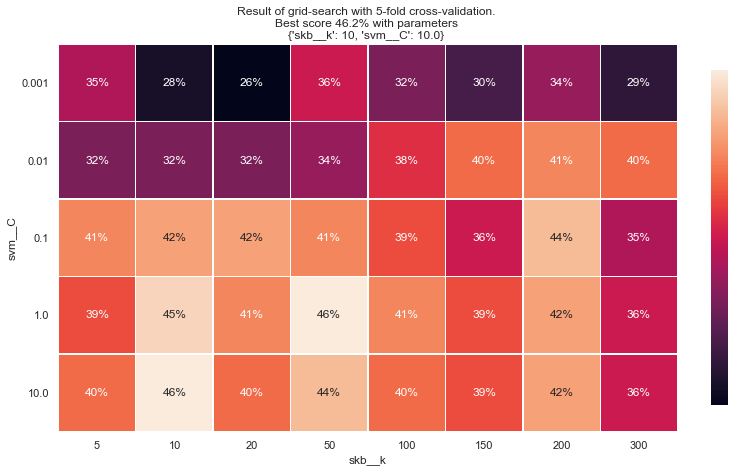

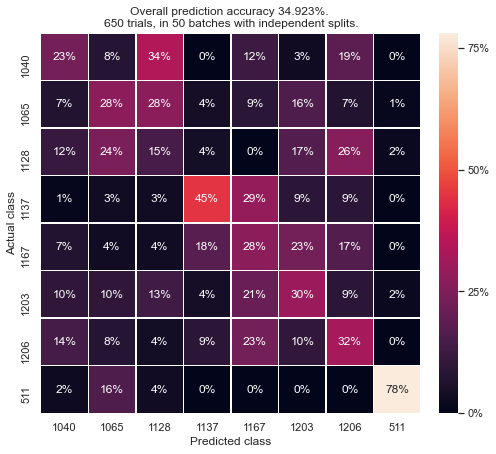

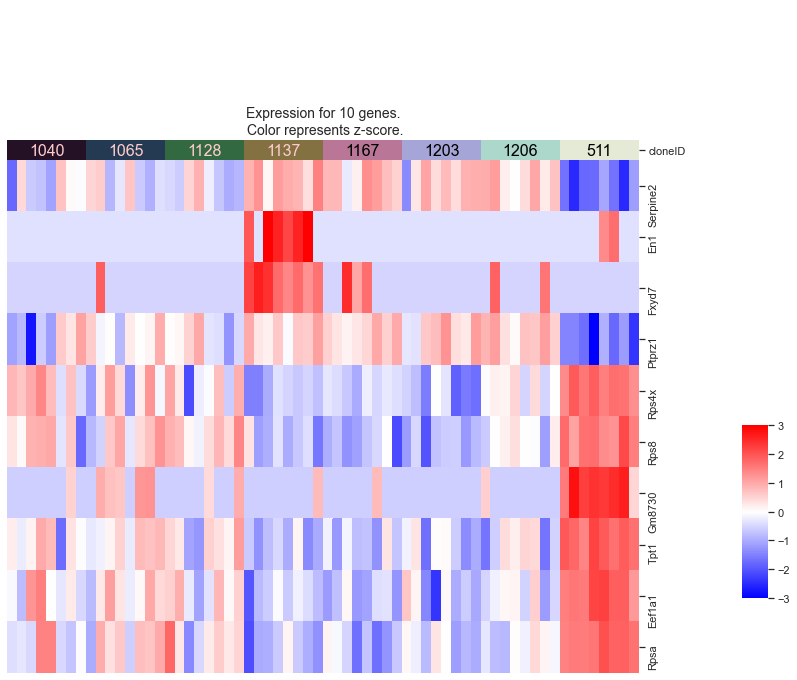

(10, 10.0)

In [88]:
type_analysis('OPC')

In [ ]:
def get_siggenes(ct, k):
    '''
    Get k most clonally significant genes within type ct.
    '''
    X = data_df.loc[cells_by_type[ct]]
    y = meta_by_type[ct].cloneID
    SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=k)),
                     ])

    SVM_pipe.fit(X,y)
    skbf = SVM_pipe.named_steps['skb']
    return list(compress(X.columns, skbf.get_support()))

def make_metagenes(ct, k, C):
    '''
    Represents SVC coefficients as a metagene, including both coefficients and genes.
    Metagenes are represented as Python dictionaries, with keys=genes, values=coefficients.
    '''
    X = data_df.loc[cells_by_type[ct]]
    y = meta_by_type[ct].cloneID
    SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=k)),
                     ('svm', LinearSVC(C = C)) ])

    SVM_pipe.fit(X,y)
    skbf = SVM_pipe.named_steps['skb']
    lsvc = SVM_pipe.named_steps['svm']

    diff_genes = list(compress(X.columns, skbf.get_support()))
    metagenes = [ dict(zip(diff_genes, coef_list)) for coef_list in lsvc.coef_]
    return metagenes

def make_metaX(X, mgs):
    mgs_genes = list(mgs[0].keys())
    df = pd.DataFrame(index = X.index, columns = ['Metagene_'+str(j) for j in range(len(mgs))])
    for j in range(len(mgs)):
        weights = pd.Series(mgs[j])
        X_weighted = X[mgs_genes].T.multiply(weights, axis=0)
        df['Metagene_'+str(j)] = X_weighted.sum(axis=0)
    return df

metagenes = {}
metagenes_small = {}



# Partition of variance (sum of squares)

To analyze the clonal contributions to gene expression variability, while accounting for the effects of cell type, region, and brain, we introduce a general purpose function for partitioning sum-of-squares variance.

In [35]:
def SS_part(df, mf, conditions, groups, minsize = 3, shuff = 0):
    '''
    Computes SS(between) and SS(total).
    Arguments:
    df -- dataframe with values.
    mf -- metadata dataframe with the same index as df.
    conditions -- a dictionary of the form column_name : value.
    groups -- a column-name from mf.
    '''
    col_bool = pd.Series(True, index=mf.index)
    for key in conditions.keys():
        col_bool = col_bool & (mf[key] == conditions[key])
    meta = mf[col_bool]
    meta_pops = meta[groups].value_counts()
    big_groups = meta_pops[meta_pops >= minsize].index
    print('Using {} groups out of {}.'.format(len(big_groups), len(meta[groups].unique())))
    meta = meta[meta[groups].isin(big_groups)]
    mcells = meta.index
    data = df.loc[mcells]
    meta = meta[groups]
    all_mean = data.mean()
    all_mean = all_mean[all_mean > 0]
    data = data[all_mean.index]
    if len(data) == 0:
        zret = pd.Series([0])
        SS_bs = pd.DataFrame(0, index = data.columns, columns = list(range(shuff)))
        return zret, zret, SS_bs 
    if len(data) != len(meta):
        raise ValueError('Metadata index does not match data index.')
    
    N = len(data) # Number of cells
    K = len(meta.unique()) # Number of groups
    
    SS_tot = (N-1) * data.var() # Time-consuming calculation
    if K == 1:
        zret = pd.Series([0])
        SS_bs = pd.DataFrame(0, index = data.columns, columns = list(range(shuff)))
        return zret,SS_tot, SS_bs
    
    F = pd.Series(ss.f_oneway(*[group.values for name, group in data.groupby(meta)]).statistic, 
                  index=data.columns)
    betw_over_within = F * (K-1) / (N-K) # between / within (sums of squares)
    eta = 1 / (1 + (1 / betw_over_within)) # This equals between / total = between / (between + within)
    SS_between = eta * SS_tot
    
    if shuff > 0:
        SS_bs = pd.DataFrame(0, index = data.columns, columns = list(range(shuff)))
        for j in range(shuff):
            meta_shuff = meta.copy()
            np.random.shuffle(meta_shuff.values)
            F = pd.Series(ss.f_oneway(*[group.values for name, group in data.groupby(meta_shuff)]).statistic, 
                  index=data.columns)
            betw_over_within = F * (K-1) / (N-K) # between / within (sums of squares)
            eta = 1 / (1 + (1 / betw_over_within)) # This equals between / total = between / (between + within)
            SS_bs[j] = eta # Temporarily SS_bs[j] stores between / total.
        SS_bs = SS_bs.multiply(SS_tot, axis=0) # Scale up by total.
        return SS_between, SS_tot, SS_bs
    else:
        return SS_between, SS_tot

First, we look at overall gene variability, and the portion explained by cell type.

In [40]:
pl_df = pd.DataFrame(index = [reg+rep for rep in reps for reg in regions ], 
                    columns = ['Total variance', 'Between cell types', 'Expected by chance'])
n = 0
for rep in reps:
    for reg in regions:
        SS_b, SS_tot, SS_b_shuff = SS_part(data_df, meta_df, {'region':reg, 'replicate':rep}, 'cell_type', shuff=10)
        count = len(meta_df[(meta_df['region'] == reg) & (meta_df['replicate'] == rep)])
        pl_df.loc[reg+rep] = {'Total variance':SS_tot.sum() / count, 
                              'Between cell types':SS_b.sum() / count,
                              'Expected by chance':SS_b_shuff.mean(axis=1).sum() / count
                             }
        n += 1
        print('{} out of {} complete'.format(n, len(reps) * len(regions)))
pl_df['Region'] = [s[:-4] for s in pl_df.index]
pl_df['Brain'] = [s[-4:] for s in pl_df.index]
pl_df

Using 13 groups out of 16.
1 out of 6 complete
Using 15 groups out of 17.
2 out of 6 complete
Using 16 groups out of 16.
3 out of 6 complete
Using 16 groups out of 18.
4 out of 6 complete
Using 15 groups out of 17.
5 out of 6 complete
Using 18 groups out of 19.
6 out of 6 complete


Total variance Between cell types Expected by chance  \
cortexrep3             2617.78            719.231            15.6134   
striatumrep3           2368.58            817.796             34.693   
hippocampusrep3        2177.13            814.787            74.4748   
cortexrep4             2523.65             647.81            31.5604   
striatumrep4           2533.35            620.257            20.6121   
hippocampusrep4        2371.16            571.229            16.3271   

                      Region Brain  
cortexrep3            cortex  rep3  
striatumrep3        striatum  rep3  
hippocampusrep3  hippocampus  rep3  
cortexrep4            cortex  rep4  
striatumrep4        striatum  rep4  
hippocampusrep4  hippocampus  rep4

In [41]:
pl_df['Cell type proportion'] = (pl_df['Between cell types'] - pl_df['Expected by chance']) / pl_df['Total variance']
pl_df

Total variance Between cell types Expected by chance  \
cortexrep3             2617.78            719.231            15.6134   
striatumrep3           2368.58            817.796             34.693   
hippocampusrep3        2177.13            814.787            74.4748   
cortexrep4             2523.65             647.81            31.5604   
striatumrep4           2533.35            620.257            20.6121   
hippocampusrep4        2371.16            571.229            16.3271   

                      Region Brain Cell type proportion  
cortexrep3            cortex  rep3             0.268784  
striatumrep3        striatum  rep3             0.330621  
hippocampusrep3  hippocampus  rep3              0.34004  
cortexrep4            cortex  rep4              0.24419  
striatumrep4        striatum  rep4             0.236701  
hippocampusrep4  hippocampus  rep4             0.234021

Across regions and replicates, we find that about 23% -- 34% of the gene expression variability is explained by cell type differences.  Next we look for clonal signals within each cell type.  The following computations will take a little while!

In [42]:
no_shuffs = 100
minsize = 3

plc_df = pd.DataFrame(index = [reg+'_'+rep+'_'+ct for rep in reps for reg in regions for ct in cell_types], 
                    columns = ['N', 'K', 'Total variance', 'Between clones'] + 
                      ['Expected by chance {}'.format(j) for j in range(no_shuffs)])
n = 0
for rep in reps:
    for reg in regions:
        for ct in cell_types:
            p_cells = meta_df[(meta_df['region'] == reg) & 
                              (meta_df['replicate'] == rep) & 
                              (meta_df['cell_type'] == ct)].index
            K_pops = meta_df.loc[p_cells].cloneID.value_counts()
            big_clones = K_pops[K_pops >= minsize].index
            K = len(big_clones)
            p_cells = [cell for cell in p_cells if meta_df.loc[cell].cloneID in big_clones]
            N = len(p_cells)
            if N > 0:
                SS_b, SS_tot, SS_b_shuff = SS_part(data_df, meta_df, {'region':reg, 'replicate':rep, 'cell_type':ct}, 
                                                   'cloneID', shuff=no_shuffs, minsize=minsize)
            
                row_dict = {'Expected by chance {}'.format(j) : (SS_b_shuff[j].sum() / count) for j in range(no_shuffs)}
                row_dict['Total variance'] = SS_tot.sum() / count
                row_dict['Between clones'] = SS_b.sum() / count
                row_dict['N'] = N
                row_dict['K'] = K
                plc_df.loc[reg+'_'+rep+'_'+ct] = row_dict
            n += 1
            if n%10 == 0:
                print('{} types complete.'.format(n))
plc_df['Region'] = [s.split('_')[0] for s in plc_df.index]
plc_df['Brain'] = [s.split('_')[1] for s in plc_df.index]
plc_df['Cell type'] = [s.split('_')[2] for s in plc_df.index]
plc_df

Using 21 groups out of 28.
Using 18 groups out of 104.
Using 6 groups out of 82.
Using 5 groups out of 105.
Using 5 groups out of 59.
10 types complete.
Using 1 groups out of 36.
Using 10 groups out of 61.
Using 11 groups out of 111.
Using 1 groups out of 7.
20 types complete.
Using 7 groups out of 16.
Using 6 groups out of 24.
Using 1 groups out of 1.
Using 3 groups out of 36.
Using 4 groups out of 60.
30 types complete.
Using 9 groups out of 65.
Using 5 groups out of 59.
Using 16 groups out of 83.
Using 10 groups out of 32.
Using 8 groups out of 40.
40 types complete.
Using 2 groups out of 5.
Using 4 groups out of 19.
Using 1 groups out of 8.
Using 3 groups out of 19.
50 types complete.
Using 5 groups out of 23.
Using 3 groups out of 26.
Using 5 groups out of 23.
Using 3 groups out of 19.
Using 11 groups out of 36.
Using 1 groups out of 14.
60 types complete.
Using 6 groups out of 14.
Using 2 groups out of 4.
Using 9 groups out of 154.
Using 4 groups out of 66.
70 types complete.
Usi

N    K Total variance Between clones  \
cortex_rep3_MG          1134   21        1060.01        20.1882   
cortex_rep3_PVM          NaN  NaN            NaN            NaN   
cortex_rep3_GMA           65   18        38.6118         10.528   
cortex_rep3_RGSZ         NaN  NaN            NaN            NaN   
cortex_rep3_WMA          NaN  NaN            NaN            NaN   
...                      ...  ...            ...            ...   
hippocampus_rep4_TEINH   NaN  NaN            NaN            NaN   
hippocampus_rep4_OBINH   NaN  NaN            NaN            NaN   
hippocampus_rep4_DGNBL   299   39        243.936        33.8232   
hippocampus_rep4_MSN     NaN  NaN            NaN            NaN   
hippocampus_rep4_DGGRC     6    2          3.493       0.814561   

                       Expected by chance 0 Expected by chance 1  \
cortex_rep3_MG                      18.4846               18.553   
cortex_rep3_PVM                         NaN                  NaN   
cortex_rep3_GMA                     10.3832              10.2135   
cortex_rep3_RGSZ                        NaN                  NaN   
cortex_rep3_WMA                         NaN                  NaN   
...                                     ...                  ...   
hippocampus_rep4_TEINH                  NaN                  NaN   
hippocampus_rep4_OBINH                  NaN                  NaN   
hippocampus_rep4_DGNBL              30.9208              31.0985   
hippocampus_rep4_MSN                    NaN                  NaN   
hippocampus_rep4_DGGRC             0.762253             0.655694   

                       Expected by chance 2 Expected by chance 3  \
cortex_rep3_MG                      18.5124              18.8381   
cortex_rep3_PVM                         NaN                  NaN   
cortex_rep3_GMA                      10.282              10.2037   
cortex_rep3_RGSZ                        NaN                  NaN   
cortex_rep3_WMA                         NaN                  NaN   
...                                     ...                  ...   
hippocampus_rep4_TEINH                  NaN                  NaN   
hippocampus_rep4_OBINH                  NaN                  NaN   
hippocampus_rep4_DGNBL              31.0102              31.3212   
hippocampus_rep4_MSN                    NaN                  NaN   
hippocampus_rep4_DGGRC             0.762902             0.762253   

                       Expected by chance 4 Expected by chance 5  ...  \
cortex_rep3_MG                      18.5549              18.5835  ...   
cortex_rep3_PVM                         NaN                  NaN  ...   
cortex_rep3_GMA                     10.3893              10.2965  ...   
cortex_rep3_RGSZ                        NaN                  NaN  ...   
cortex_rep3_WMA                         NaN                  NaN  ...   
...                                     ...                  ...  ...   
hippocampus_rep4_TEINH                  NaN                  NaN  ...   
hippocampus_rep4_OBINH                  NaN                  NaN  ...   
hippocampus_rep4_DGNBL              31.0853              30.8542  ...   
hippocampus_rep4_MSN                    NaN                  NaN  ...   
hippocampus_rep4_DGGRC             0.664839             0.648384  ...   

                       Expected by chance 93 Expected by chance 94  \
cortex_rep3_MG                        18.567               18.9747   
cortex_rep3_PVM                          NaN                   NaN   
cortex_rep3_GMA                      10.3245               10.2397   
cortex_rep3_RGSZ                         NaN                   NaN   
cortex_rep3_WMA                          NaN                   NaN   
...                                      ...                   ...   
hippocampus_rep4_TEINH                   NaN                   NaN   
hippocampus_rep4_OBINH                   NaN                   NaN   
hippocampus_rep4_DGNBL               30.5905                31.023   
hippocampus

We look for signals of clonality in gene expression, by seeing where the clonal contribution to gene expression variance exceeds the result of 100 permutation tests (clone labels permuted within each region/replicate/cell type).

In [65]:
chance_cols = ['Expected by chance {}'.format(j) for j in range(no_shuffs)]
clonal_signals = plc_df['Between clones'] > plc_df[chance_cols].max(axis=1)
clonal_signals[clonal_signals].index

Index(['cortex_rep3_MG', 'cortex_rep3_GMA', 'cortex_rep3_OPC',
       'cortex_rep3_COP', 'striatum_rep3_MG', 'striatum_rep3_GMA',
       'striatum_rep3_OBNBL', 'hippocampus_rep3_OPC', 'hippocampus_rep3_MFOL',
       'hippocampus_rep3_TEGLU', 'cortex_rep4_WMA', 'cortex_rep4_TEGLU',
       'striatum_rep4_MG', 'striatum_rep4_OPC', 'striatum_rep4_nIPC',
       'striatum_rep4_OBNBL', 'hippocampus_rep4_WMA', 'hippocampus_rep4_OPC',
       'hippocampus_rep4_COP', 'hippocampus_rep4_TEGLU',
       'hippocampus_rep4_nIPC', 'hippocampus_rep4_DGNBL'],
      dtype='object')

The following bar charts show the clonal signal, as colored bars rising above the gray bars arising from chance (maximum from 100 permutations).

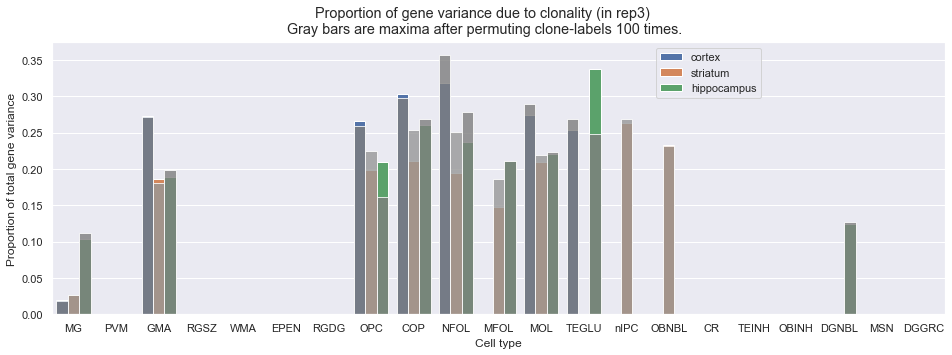

In [63]:
fig, ax = plt.subplots(1,1,figsize=(16,5))

plot_df = plc_df[plc_df['Brain'] == 'rep3'].copy()
plot_df['Clonal proportion of variance'] = plot_df['Between clones'] / plot_df['Total variance']
sns.barplot(x='Cell type', y="Clonal proportion of variance", hue="Region", saturation = 0.85, data=plot_df, ax=ax)

handles, labels = ax.get_legend_handles_labels()

chance_cols = ['Expected by chance {}'.format(j) for j in range(no_shuffs)]
plot_df['Max_chance'] = plot_df[chance_cols[:no_shuffs]].max(axis=1) / plot_df['Total variance']
sns.barplot(x="Cell type", y="Max_chance", hue='Region', saturation = 0, data=plot_df, ax=ax, alpha=0.8)

ax.set_ylabel('Proportion of total gene variance')
ax.set_xlabel('Cell type')

#plt.legend(bbox_to_anchor=(1, 1))
plt.legend(handles[:3], labels[:3], bbox_to_anchor=(0.8, 1))

plt.suptitle('Proportion of gene variance due to clonality (in rep3) \n'
            'Gray bars are maxima after permuting clone-labels {} times.'.format(no_shuffs))

plt.show()

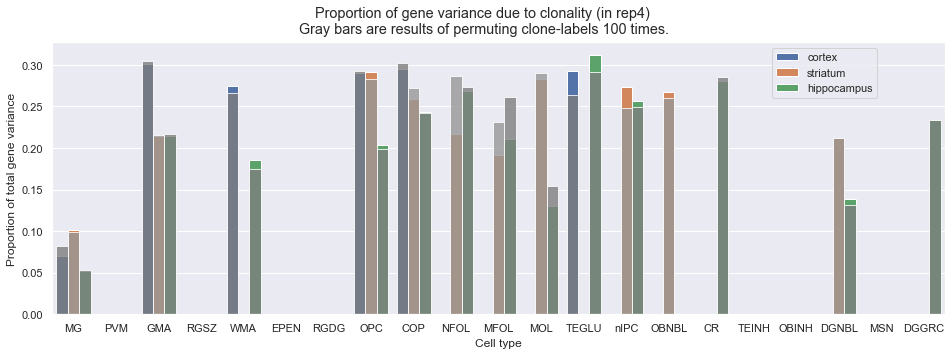

In [64]:
fig, ax = plt.subplots(1,1,figsize=(16,5))

plot_df = plc_df[plc_df['Brain'] == 'rep4'].copy()
plot_df['Clonal proportion of variance'] = plot_df['Between clones'] / plot_df['Total variance']
sns.barplot(x='Cell type', y="Clonal proportion of variance", hue="Region", saturation = 0.85, data=plot_df, ax=ax)

handles, labels = ax.get_legend_handles_labels()

chance_cols = ['Expected by chance {}'.format(j) for j in range(no_shuffs)]
plot_df['Max_chance'] = plot_df[chance_cols[:no_shuffs]].max(axis=1) / plot_df['Total variance']
sns.barplot(x="Cell type", y="Max_chance", hue='Region', saturation = 0, data=plot_df, ax=ax, alpha=0.8)


ax.set_ylabel('Proportion of total gene variance')
ax.set_xlabel('Cell type')

#plt.legend(bbox_to_anchor=(1, 1))
plt.legend(handles[:3], labels[:3], bbox_to_anchor=(0.8, 1))

plt.suptitle('Proportion of gene variance due to clonality (in rep4) \n'
            'Gray bars are results of permuting clone-labels {} times.'.format(no_shuffs))

plt.show()

The clonal signal is somewhat weak here, but statistically significant.  Instead of looking at contributions to overal gene variance, we consider numbers of clonally significant genes in what follows.

# Clonally significant genes.

We begin with some general-purpose routines for extracting lists of cells satisfying certain conditions.

In [45]:
def get_group_sizes(mf, conditions, groups, minsize=3):
    boolcol = pd.Series(True, index=mf.index)
    for key in conditions.keys():
        boolcol = boolcol & (mf[key] == conditions[key])
    meta = mf[boolcol]
    pops = meta[groups].value_counts()
    return pops[pops >= minsize].values

In [46]:
def get_cells(mf, conditions, groups, minsize=3):
    boolcol = pd.Series(True, index=mf.index)
    for key in conditions.keys():
        boolcol = boolcol & (mf[key] == conditions[key])
    meta = mf[boolcol]
    pops = meta[groups].value_counts()
    good_groups = pops[pops >= minsize].index
    meta = meta[meta[groups].isin(good_groups)]
    return meta.index

Next, we introduce a specialized tool for permutation tests.  This produes permutations which disrupt existing group structures.  For example, if we want 10 permutations of clone labels, we product 100 permutations instead.  We "score" these by looking at how many distinct labels each old clone receives.  I.e., if an old clone A has three cells 1,2,3, and these are assigned labels B,C,D instead of A,A,A, then we give it a score of 3 (three distinct labels).  We then take the top 10 permutations, by this score.  

This mitigates some issues with clonal structure being preserved by some permutations and not by others... a significant issue when there are pretty small samples.

In [66]:
def make_shuff(meta, no_shuffs=10, topratio = 10):
    ms_df = pd.DataFrame(index=meta.index)
    score = {}
    for j in range(no_shuffs * topratio):
        ms = meta.copy()
        np.random.shuffle(ms.values)
        ss = 'Shuffle_{}'.format(j)
        ms_df[ss] = ms
        score[ss] = 0
        meta_pops = meta.value_counts()
        for group in meta_pops.index:
            score[ss] += len(ms[meta == group].unique())
    score = pd.Series(score)
    score = score.sort_values()[-no_shuffs:]
    ms_df = ms_df[score.index]
    ms_df.columns = ['Shuffle_{}'.format(j) for j in range(no_shuffs)]
    return ms_df

Now we count the clonally significant genes, by ANOVA F p<0.01, within each region/replicate/cell-type, and compare to the number of such genes found by chance (permuting the clone labels).  We restrict to clones with at least 3 cells at all times.

In [67]:
no_shuffs = 100
minsize = 3

genevar_df = pd.DataFrame(index = [reg+'_'+rep+'_'+ct for rep in reps for reg in regions for ct in cell_types], 
                    columns = ['N', 'K', 'Number of sig genes'] + 
                      ['Expected by chance {}'.format(j) for j in range(no_shuffs)])
n = 0
for rep in reps:
    for reg in regions:
        for ct in cell_types:
            rowlabel = reg+'_'+rep+'_'+ct
            p_cells = meta_df[(meta_df['region'] == reg) & 
                              (meta_df['replicate'] == rep) & 
                              (meta_df['cell_type'] == ct)].index
            K_pops = meta_df.loc[p_cells].cloneID.value_counts()
            big_clones = K_pops[K_pops >= minsize].index
            K = len(big_clones)
            p_cells = [cell for cell in p_cells if meta_df.loc[cell].cloneID in big_clones]
            N = len(p_cells)
            genevar_df.loc[rowlabel,'N'] = N
            genevar_df.loc[rowlabel,'K'] = K
            
            if N > 0:
                    data = data_df.loc[p_cells].copy()
                    ggenes = data.columns
                    ggenes = ggenes[data.max() > 0] # Filter out genes not expressed by chosen cells
                    data = data[ggenes]
                    meta = meta_df.loc[p_cells].cloneID.copy()
                    print('Using {} clones with {} cells in {}.'.format(K, N, rowlabel))
                    pvals = pd.Series(ss.f_oneway(*[group.values for name, group in data.groupby(meta)]).pvalue, 
                                      index=data.columns)
                    genevar_df.loc[rowlabel,'Number of sig genes'] = (pvals < 0.01).sum()
                    ms_df = make_shuff(meta, no_shuffs=no_shuffs)
                    for j in range(no_shuffs):
                        meta = ms_df['Shuffle_{}'.format(j)]
                        pvals = pd.Series(ss.f_oneway(*[group.values for name, group in data.groupby(meta)]).pvalue, 
                                          index=data.columns)
                        if (pvals < 0.01).sum() > 1000:
                            genelist = pvals[pvals < 0.01].index
                            badmeta = meta.copy()
                            badrow = rowlabel
                            raise ValueError('Eeek!')
                            #vis_genebars(vis_genebars(data, meta, genelist, 'cloneID'))
                            break
                        genevar_df.loc[rowlabel,'Expected by chance {}'.format(j)] = (pvals < 0.01).sum()
                    
genevar_df.head()

Using 21 clones with 1134 cells in cortex_rep3_MG.
Using 18 clones with 65 cells in cortex_rep3_GMA.
Using 6 clones with 21 cells in cortex_rep3_OPC.
Using 5 clones with 16 cells in cortex_rep3_COP.
Using 5 clones with 15 cells in cortex_rep3_NFOL.
Using 1 clones with 3 cells in cortex_rep3_MFOL.
Using 10 clones with 35 cells in cortex_rep3_MOL.
Using 11 clones with 43 cells in cortex_rep3_TEGLU.
Using 1 clones with 3 cells in cortex_rep3_OBNBL.
Using 7 clones with 244 cells in striatum_rep3_MG.
Using 6 clones with 30 cells in striatum_rep3_GMA.
Using 1 clones with 3 cells in striatum_rep3_EPEN.
Using 3 clones with 11 cells in striatum_rep3_OPC.
Using 4 clones with 15 cells in striatum_rep3_COP.
Using 9 clones with 38 cells in striatum_rep3_NFOL.
Using 5 clones with 26 cells in striatum_rep3_MFOL.
Using 16 clones with 79 cells in striatum_rep3_MOL.
Using 10 clones with 37 cells in striatum_rep3_nIPC.
Using 8 clones with 32 cells in striatum_rep3_OBNBL.
Using 2 clones with 11 cells in h

N   K Number of sig genes Expected by chance 0  \
cortex_rep3_MG    1134  21                 699                  636   
cortex_rep3_PVM      0   0                 NaN                  NaN   
cortex_rep3_GMA     65  18                 233                  199   
cortex_rep3_RGSZ     0   0                 NaN                  NaN   
cortex_rep3_WMA      0   0                 NaN                  NaN   

                 Expected by chance 1 Expected by chance 2  \
cortex_rep3_MG                    617                  655   
cortex_rep3_PVM                   NaN                  NaN   
cortex_rep3_GMA                   179                  222   
cortex_rep3_RGSZ                  NaN                  NaN   
cortex_rep3_WMA                   NaN                  NaN   

                 Expected by chance 3 Expected by chance 4  \
cortex_rep3_MG                    714                  810   
cortex_rep3_PVM                   NaN                  NaN   
cortex_rep3_GMA                   200                  196   
cortex_rep3_RGSZ                  NaN                  NaN   
cortex_rep3_WMA                   NaN                  NaN   

                 Expected by chance 5 Expected by chance 6  ...  \
cortex_rep3_MG                    704                  675  ...   
cortex_rep3_PVM                   NaN                  NaN  ...   
cortex_rep3_GMA                   182                  208  ...   
cortex_rep3_RGSZ                  NaN                  NaN  ...   
cortex_rep3_WMA                   NaN                  NaN  ...   

                 Expected by chance 90 Expected by chance 91  \
cortex_rep3_MG                     625                   774   
cortex_rep3_PVM                    NaN                   NaN   
cortex_rep3_GMA                    177                   229   
cortex_rep3_RGSZ                   NaN                   NaN   
cortex_rep3_WMA                    NaN                   NaN   

                 Expected by chance 92 Expected by chance 93  \
cortex_rep3_MG                     646                   671   
cortex_rep3_PVM                    NaN                   NaN   
cortex_rep3_GMA                    201                   165   
cortex_rep3_RGSZ                   NaN                   NaN   
cortex_rep3_WMA                    NaN                   NaN   

                 Expected by chance 94 Expected by chance 95  \
cortex_rep3_MG                     663                   708   
cortex_rep3_PVM                    NaN                   NaN   
cortex_rep3_GMA                    181                   197   
cortex_rep3_RGSZ                   NaN                   NaN   
cortex_rep3_WMA                    NaN                   NaN   

                 Expected by chance 96 Expected by chance 97  \
cortex_rep3_MG                     674                   799   
cortex_rep3_PVM                    NaN                   NaN   
cortex_rep3_GMA                    159                   189   
cortex_rep3_RGSZ                   NaN                   NaN   
cortex_rep3_WMA                    NaN                   NaN   

                 Expected by chance 98 Expected by chance 99  
cortex_rep3_MG                     718                   703  
cortex_rep3_PVM                    NaN                   NaN  
cortex_rep3_GMA                    172                   176  
cortex_rep3_RGSZ                   NaN                   NaN  
cortex_rep3_WMA                    NaN                   NaN  

[5 rows x 103 columns]

In [68]:
genevar_df = genevar_df[genevar_df['N'] > 0]
genevar_df = genevar_df[genevar_df['K'] > 1]
genevar_df['Region'] = [s.split('_')[0] for s in genevar_df.index]
genevar_df['Brain'] = [s.split('_')[1] for s in genevar_df.index]
genevar_df['Cell type'] = [s.split('_')[2] for s in genevar_df.index]
chance_cols = ['Expected by chance {}'.format(j) for j in range(no_shuffs)]
genevar_df['Mean_chance'] = genevar_df[chance_cols[:no_shuffs]].mean(axis=1)
genevar_df['Std_chance'] = genevar_df[chance_cols[:no_shuffs]].std(axis=1)
genevar_df['z_score'] = (genevar_df['Number of sig genes'] - genevar_df['Mean_chance'] ) / genevar_df['Std_chance']
genevar_df = genevar_df.sort_values(['Cell type','Region','Brain'])
genevar_df.head()

N   K Number of sig genes Expected by chance 0  \
cortex_rep3_COP        16   5                 204                   98   
cortex_rep4_COP        22   7                 120                   98   
hippocampus_rep3_COP   19   5                 208                  107   
hippocampus_rep4_COP  140  33                 364                  254   
striatum_rep3_COP      15   4                  99                   84   

                     Expected by chance 1 Expected by chance 2  \
cortex_rep3_COP                        96                   66   
cortex_rep4_COP                       119                   99   
hippocampus_rep3_COP                  123                   98   
hippocampus_rep4_COP                  198                  192   
striatum_rep3_COP                      78                   85   

                     Expected by chance 3 Expected by chance 4  \
cortex_rep3_COP                        99                   95   
cortex_rep4_COP                       101                   90   
hippocampus_rep3_COP                   90                  135   
hippocampus_rep4_COP                  227                  225   
striatum_rep3_COP                      63                   69   

                     Expected by chance 5 Expected by chance 6  ...  \
cortex_rep3_COP                        66                   93  ...   
cortex_rep4_COP                       105                   97  ...   
hippocampus_rep3_COP                  141                  124  ...   
hippocampus_rep4_COP                  191                  207  ...   
striatum_rep3_COP                      99                   71  ...   

                     Expected by chance 96 Expected by chance 97  \
cortex_rep3_COP                        102                   106   
cortex_rep4_COP                        137                   109   
hippocampus_rep3_COP                    98                   113   
hippocampus_rep4_COP                   168                   193   
striatum_rep3_COP                       90                    87   

                     Expected by chance 98 Expected by chance 99       Region  \
cortex_rep3_COP                         98                    82       cortex   
cortex_rep4_COP                         77                    81       cortex   
hippocampus_rep3_COP                   115                    97  hippocampus   
hippocampus_rep4_COP                   216                   158  hippocampus   
striatum_rep3_COP                       74                    58     striatum   

                     Brain Cell type Mean_chance Std_chance   z_score  
cortex_rep3_COP       rep3       COP       95.93  14.729380   7.33704  
cortex_rep4_COP       rep4       COP       99.51  14.475681   1.41548  
hippocampus_rep3_COP  rep3       COP      113.70  18.170628   5.18969  
hippocampus_rep4_COP  rep4       COP      207.51  24.637368   6.35173  
striatum_rep3_COP     rep3       COP       85.91  19.291541  0.678536  

[5 rows x 109 columns]

Now we visualize the results, to see the excess (beyond chance) in the numbers of clonally significant genes within each region/replicate/cell-type.

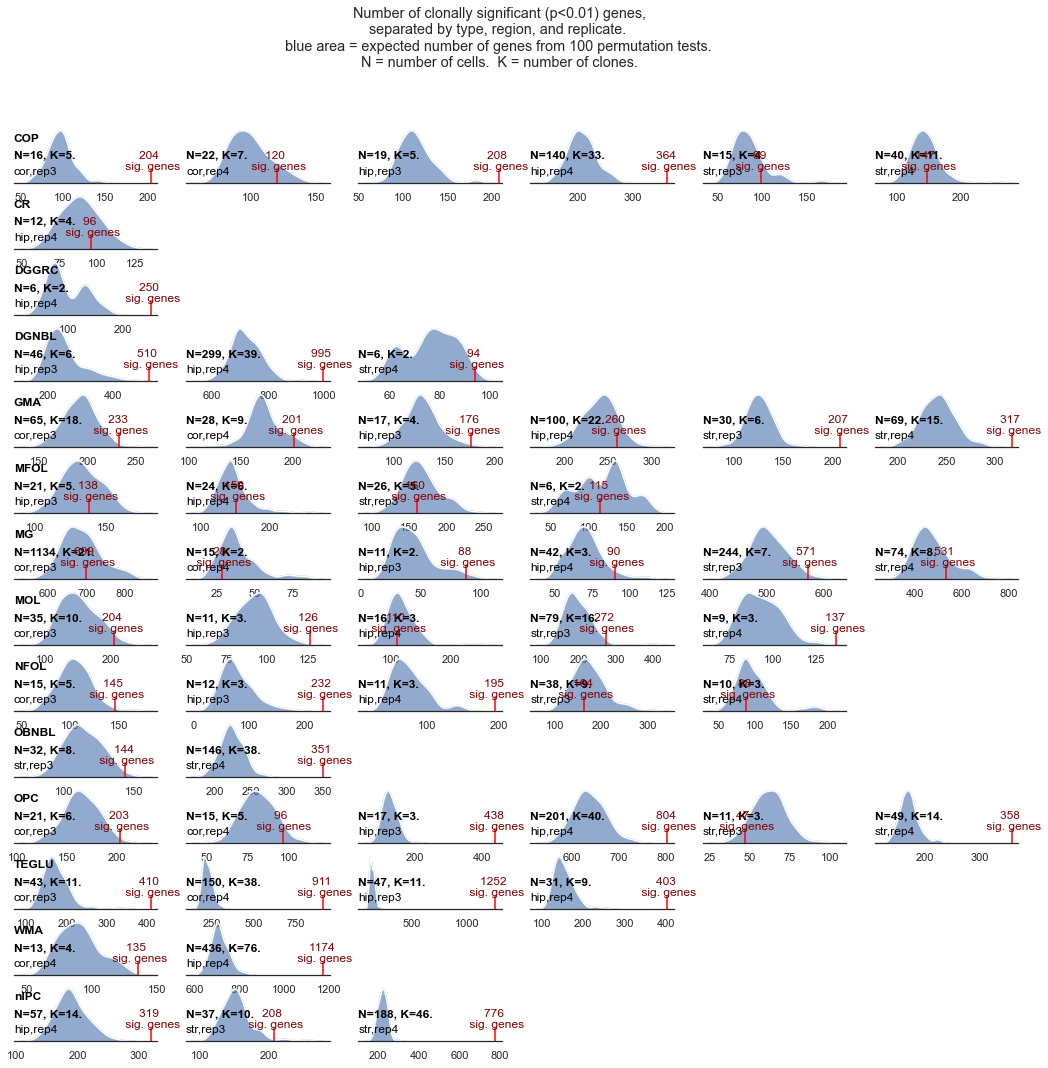

In [70]:
no_rows = len(genevar_df['Cell type'].unique())

fig, ax = plt.subplots(no_rows,6,figsize=(18,1.2*no_rows))
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

for i,ct in enumerate(genevar_df['Cell type'].unique()):
    for j,row in enumerate(genevar_df[genevar_df['Cell type'] == ct].index):   
        sns.kdeplot(genevar_df.loc[row][chance_cols], clip_on=False, shade=True, alpha=0.6, ax=ax[i,j], legend=False)
        sns.kdeplot(genevar_df.loc[row][chance_cols], clip_on=False, color='w', alpha=1, ax=ax[i,j], legend=False)
        N = genevar_df.loc[row]['N']
        K = genevar_df.loc[row]['K']
        ax[i,j].set_yticks([])
        ax[i,j].set_title('')
        if j == 0:
            ax[i,j].text(0, .8, '{}'.format(ct,N,K), fontweight="bold", color='black', 
                         ha="left", va="center", transform=ax[i,j].transAxes)
            
        
        regrep = genevar_df.loc[row]['Region'][:3]+','+genevar_df.loc[row]['Brain']
        ax[i,j].text(0, .2, regrep, color='black',
                ha="left", va="center", transform=ax[i,j].transAxes)
        
        nosig = genevar_df.loc[row]['Number of sig genes']
        ax[i,j].axvline(nosig, ymax=0.25, color='red')
        trans = ax[i,j].get_xaxis_transform()
        ax[i,j].text(0, .5, 'N={}, K={}.'.format(N,K), fontweight="bold", color='black', 
                         ha="left", va="center", transform=ax[i,j].transAxes)
        ax[i,j].text(nosig, 0.2, '{} \n sig. genes'.format(nosig), color=(0.5,0,0), 
                     ha='center', va='bottom', transform=trans)
    cmin = len(genevar_df[genevar_df['Cell type'] == ct])
    for j in range(cmin,6):
        ax[i,j].set_visible(False)
sns.despine(left=True)

plt.suptitle('Number of clonally significant (p<0.01) genes,\n'
             'separated by type, region, and replicate. \n'
            'blue area = expected number of genes from 100 permutation tests. \n'
            'N = number of cells.  K = number of clones.')

plt.show()
#sns.set_titles("")
#sns.set(yticks=[])


fig.subplots_adjust(hspace=.5)

# Remove axes details that don't play well with overlap



Now we look at the z-scores for each count of significant genes.  We see if these are correlated to the number of clones in the sample.  

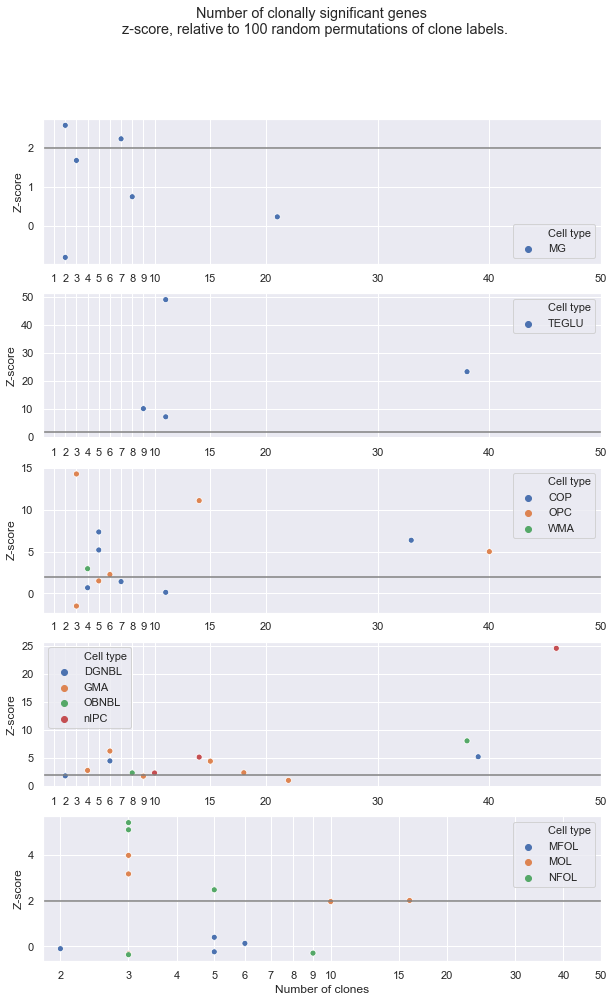

In [71]:
ct_groups = [['MG'], ['TEGLU'], ['WMA','OPC','COP'],
            ['nIPC','DGNBL','GMA','OBNBL'],
            ['NFOL','MFOL','MOL']]

sns.set()
fig,ax = plt.subplots(len(ct_groups), 1, figsize=(10,len(ct_groups)*3.1))

plt.xscale('log')
xt = [1,2,3,4,5,6,7,8,9,10,15,20,30,40,50]
for j in range(len(ct_groups)):
    ax[j].set_xticks(xt)
    ax[j].set_xticklabels([str(i) for i in xt])
    sns.scatterplot(x='K', y='z_score', hue='Cell type', 
                    data=genevar_df[genevar_df['Cell type'].isin(ct_groups[j])], ax= ax[j])
    if j == len(ct_groups)-1:
        ax[j].set_xlabel('Number of clones')
    else:
        ax[j].set_xlabel('')
    ax[j].set_xlim(0,50)
    ax[j].set_ylabel('Z-score')
    ax[j].axhline(2.0, color='gray')
plt.suptitle('Number of clonally significant genes \n z-score, relative to 100 random permutations of clone labels.')
plt.show()

# Examination of significant genes

Now, instead of *numbers* of significant genes, we actually list them and make some heatmaps.  We use a permutation-test method of detecting clonally significant genes, taking those whose interclonal variance is at least 1 standard deviation above the *maximum* of 100 permutations.

In [73]:
def get_sig_genes(df, mf, conditions, groups, minsize=3, shuff=0):
    SS_b, SS_tot, SS_b_shuff = SS_part(df, mf, conditions, groups, minsize=3, shuff=shuff)
    return SS_b, SS_b_shuff

In [55]:
clone_gene_df = pd.DataFrame(index = clonal_signals[clonal_signals].index)
clone_gene_df['Region'] = plc_df['Region']
clone_gene_df['Brain'] = plc_df['Brain']
clone_gene_df['Cell_type'] = plc_df['Cell type']
clone_gene_df['Genes'] = np.empty((len(clone_gene_df), 0)).tolist()

for cs in clone_gene_df.index:
    cgd = clone_gene_df.loc[cs]
    cgd_dict = {'region':cgd.Region, 'replicate':cgd.Brain, 'cell_type':cgd.Cell_type}
    clone_gene_df.loc[cs,'Number_of_clones'] = len(get_group_sizes(meta_df, cgd_dict, 'cloneID'))
    SS_b, SS_b_shuff = get_sig_genes(data_df, meta_df, cgd_dict, 'cloneID', shuff=100)
    genelist = list(SS_b[SS_b > (SS_b_shuff.max(axis=1) + SS_b_shuff.std(axis=1)) ].index)
    clone_gene_df.at[cs, 'Genes'] = genelist
    print('Genes for {}:  {}'.format(cs, ', '.join(genelist)))
    print('\n --------------------------------------------------- \n')
    
clone_gene_df.head()

Using 21 groups out of 28.
Genes for cortex_rep3_MG:  Jph1, Serpine2, Gpr39, Igsf8, Cd34, Calcrl, Plcb2, Oip5, Fam110a, Pmepa1, Ctsz, Xlr, Xlr4b, Tex11, Rps4x, P2ry12, Gm37035, Fnip2, Lrrc71, Ctss, Gm35507, Gstm5, Gm6602, Dnajb4, Col9a2, Marcksl1, Trim63, Nipal3, Zfp951, Ubl3, Tmem176b, Tmem176a, Herc3, Hk2, Chchd4, Cd9, Klrd1, Klri2, Apoe, Plekha4, Rgs10, Cd81, Gas2l3, Mmp19, Asah1, Ifi30, Ier2, Man2b1, Slc7a7, Bnip3l, Hinfp, Cul5, 4930524O07Rik, Gpx1, Nradd, Ccrl2, Ccr1, Ccr5, Sfi1, Ebf1, Sparc, Chrnb1, Flot2, Evi2a, AI662270, Ngfr, 9930022D16Rik, Ttyh2, Wdr41, Hexb, Gpx8, Hspb3, Lgmn, Ifi27, Ckb, Sepp1, Cpq, Pop1, Nfkbiz, Uhrf1bp1, Hspa1b, Hspa1a, Ier3, Kat2b, Erdr1, Mro, Cfl1, Mpeg1, As3mt, PISD, chrH2B-EGFP-N

 --------------------------------------------------- 

Using 18 groups out of 104.
Genes for cortex_rep3_GMA:  A830018L16Rik, Tmem177, Smg7, Garnl3, Shc1, Kcnq4, Lsm10, Nol9, Ppm1g, Scfd2, Naaa, Cnot6l, Ubc, Upk3bl, Rab43, Tmc4, Kctd14, Rnf121, Marcks, Pald1, Slc39a3, Pan2, 

Genes for cortex_rep4_WMA:  Slc1a2, Mpped2, Crls1, Ctsa, Cdh4, Mccc1, Cox7b2, Pop5, Mest, Ech1, Prss23, Copb1, Cpe, Cenpv, Myo18a, Sez6, Igfbp4, Cacng4, Ccdc127, Bdp1, Eif3d, 0610011F06Rik, Rpl7l1, Celf4

 --------------------------------------------------- 

Using 38 groups out of 209.
Genes for cortex_rep4_TEGLU:  Pcmtd1, Pantr1, Pou3f3, Sumo1, Epha4, Ptma, C1ql2, Atp2b4, Tnr, Mgst3, 6330403A02Rik, H3f3a, Cnih3, C1ql3, Garnl3, Rprm, Tank, Tbr1, Kcnh7, Scn1a, Itgav, D430041D05Rik, Rasgrp1, Eid1, Ptpra, Lamp5, Dynlrb1, Nnat, Sulf2, Pmepa1, Gnas, Gm14296, Syp, Fhl1, L1cam, Il1rapl1, Slc16a2, Wbp5, Ngfrap1, Ap1s2, Glra2, Stmn2, Fabp5, Slc7a14, Slc25a31, Sertm1, Slitrk3, Pmvk, Pde4dip, Igsf3, Atp1a1, Syt6, Kcnd3, Camk2d, Npnt, Cenpe, Tspan5, Lmo4, Adgrl2, Negr1, Penk, Pou3f2, Fut9, Dctn3, Gm10600, Shb, Grin3a, Txn1, Prpf4, Slc24a2, Ybx1, Adgrb2, Atpif1, Stmn1, Rpl11, Cdc42, Gm13025, Clstn1, Cacna2d1, Gm1673, Wfs1, Ldb2, Pcdh7, Rell1, Gabra2, Kit, Dynll1, Rplp0, Rnft2, Cux2, Tmem132b, Rimb

Genes for hippocampus_rep4_COP:  Asic4, Neu4, Tmem81, Esrrg, Celf1, Xlr3b, Rps4x, Acsl4, Rps3a1, Hivep3, Rps6ka1, Cyp51, Tada2b, Wsb2, Fam101a, Nxph1, Alms1, Tsen34, Zfp551, Snrpa, Rps13, Tspan32, Cdkn1c, Sirt1, Ano4, Asb5, Lsm4, Rpl18a, Nacc1, Mt1, Cx3cl1, Gm26747, Clu, Stk24, Ldlr, Rpl10-ps3, Cryab, Man2c1, Eef1a1, Gm2a, Galnt10, 9330160F10Rik, Chd3, Gdpd1, Rpl23, Map2k6, Idi1, Fam120a, Hmgcr, Parp8, Prima1, Ghr, Fbxl6, 0610012G03Rik, Hspa1b, Lrp5, B4gat1, Ccnj, PISD, chrH2B-EGFP-N

 --------------------------------------------------- 

Using 9 groups out of 40.
Genes for hippocampus_rep4_TEGLU:  Pantr1, Dner, Bok, Ptgs2, Ankrd45, Tiprl, A430105J06Rik, Olfm1, Lypd6, Tspan18, Rasgrp1, Insm1, Sulf2, Rbm38, Gnas, Gm14295, Pabpc5, Sass6, Slc39a8, Negr1, Epha7, Reck, Nfia, Pou3f1, Rspo1, Slc35f6, Atp8a1, Adamts3, Prdm8, Rph3a, Mest, Foxp1, Grin2b, Kmt2b, Rbm42, Scn1b, Rcn3, Dbp, Osbpl5, Lrrc75b, Atp2b1, Fgfr1, Galnt7, Car7, Calb2, Cdh15, Abhd6, Synpr, Rnase4, Zfp810, Atm, Loxl1, Tipin, Co

Region Brain Cell_type  \
cortex_rep3_MG      cortex  rep3        MG   
cortex_rep3_GMA     cortex  rep3       GMA   
cortex_rep3_OPC     cortex  rep3       OPC   
cortex_rep3_COP     cortex  rep3       COP   
striatum_rep3_MG  striatum  rep3        MG   

                                                              Genes  \
cortex_rep3_MG    [Jph1, Serpine2, Gpr39, Igsf8, Cd34, Calcrl, P...   
cortex_rep3_GMA   [A830018L16Rik, Tmem177, Smg7, Garnl3, Shc1, K...   
cortex_rep3_OPC   [Serpine2, Pfdn4, Zfx, Gabbr2, Lias, Tmem135, ...   
cortex_rep3_COP   [Pdcl3, Nfasc, 4930402H24Rik, Zcchc12, Tmem59,...   
striatum_rep3_MG  [Rpl7, Ttll4, Obsl1, Slc16a14, Ier5, Vim, Cacf...   

                  Number_of_clones  
cortex_rep3_MG                21.0  
cortex_rep3_GMA               18.0  
cortex_rep3_OPC                6.0  
cortex_rep3_COP                5.0  
striatum_rep3_MG               7.0

In [57]:
clone_gene_df = clone_gene_df.sort_values('Cell_type')
clone_gene_df.head()

Region Brain Cell_type  \
hippocampus_rep4_COP    hippocampus  rep4       COP   
cortex_rep3_COP              cortex  rep3       COP   
hippocampus_rep4_DGNBL  hippocampus  rep4     DGNBL   
cortex_rep3_GMA              cortex  rep3       GMA   
striatum_rep3_GMA          striatum  rep3       GMA   

                                                                    Genes  \
hippocampus_rep4_COP    [Asic4, Neu4, Tmem81, Esrrg, Celf1, Xlr3b, Rps...   
cortex_rep3_COP         [Pdcl3, Nfasc, 4930402H24Rik, Zcchc12, Tmem59,...   
hippocampus_rep4_DGNBL  [Sulf1, Lactb2, Pantr1, Nab1, Epha4, Prrc2c, W...   
cortex_rep3_GMA         [A830018L16Rik, Tmem177, Smg7, Garnl3, Shc1, K...   
striatum_rep3_GMA       [Mars2, Lypd1, Pmpca, Meis2, Dlgap4, Arx, Ap4b...   

                        Number_of_clones  
hippocampus_rep4_COP                33.0  
cortex_rep3_COP                      5.0  
hippocampus_rep4_DGNBL              39.0  
cortex_rep3_GMA                     18.0  
striatum_rep3_GMA                    6.0

Here we create heatmaps for each of the "signals" and gene lists above.  We order the genes in order to better see the putative markers for each clone.

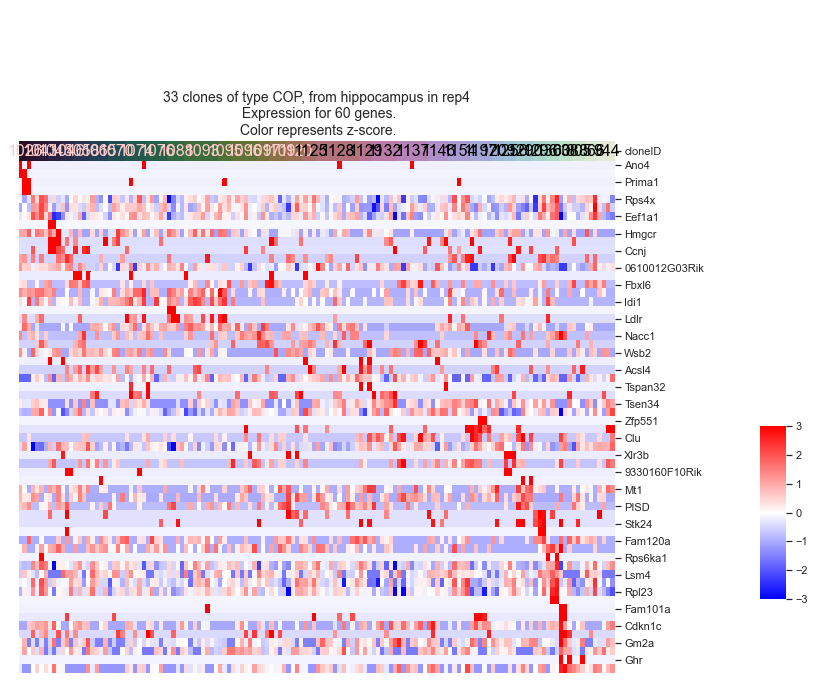

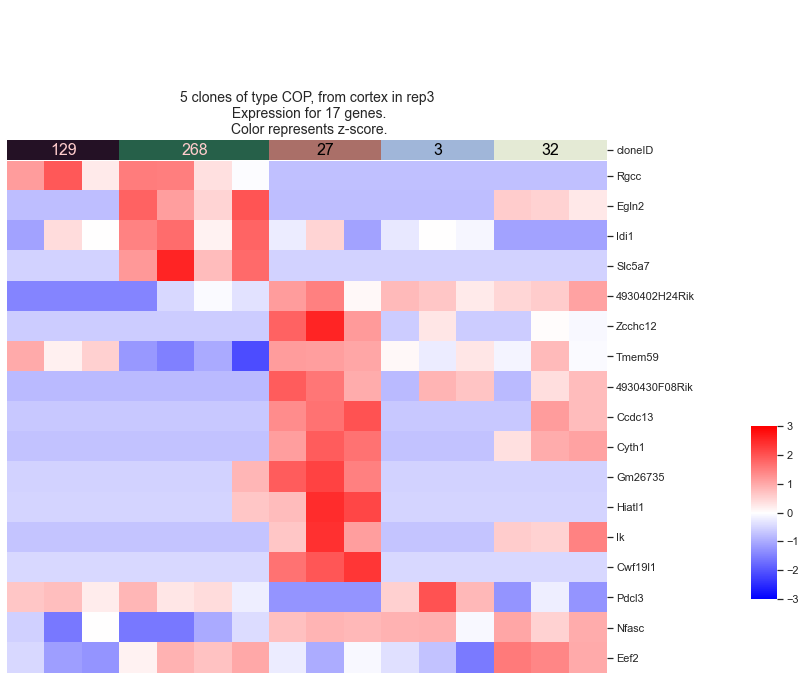

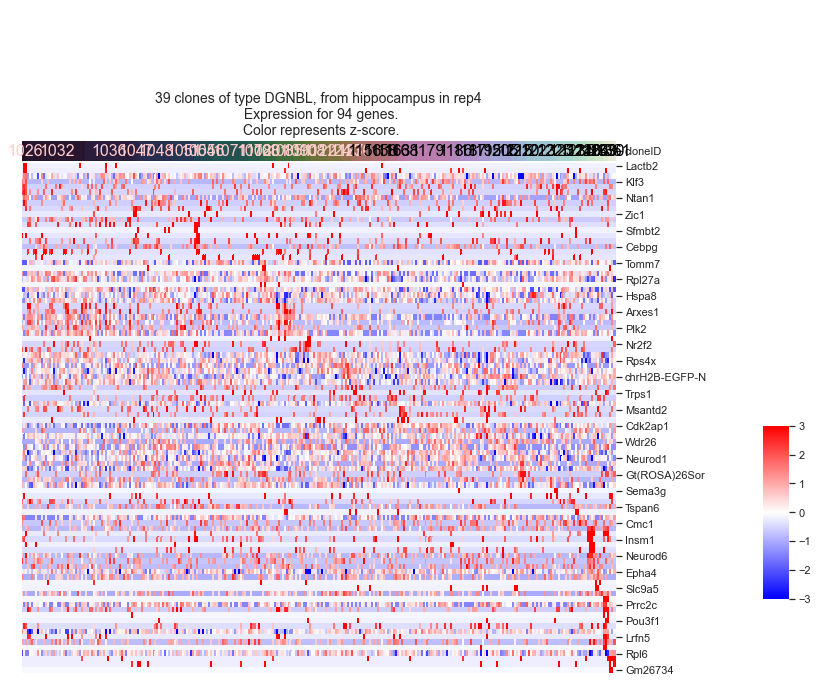

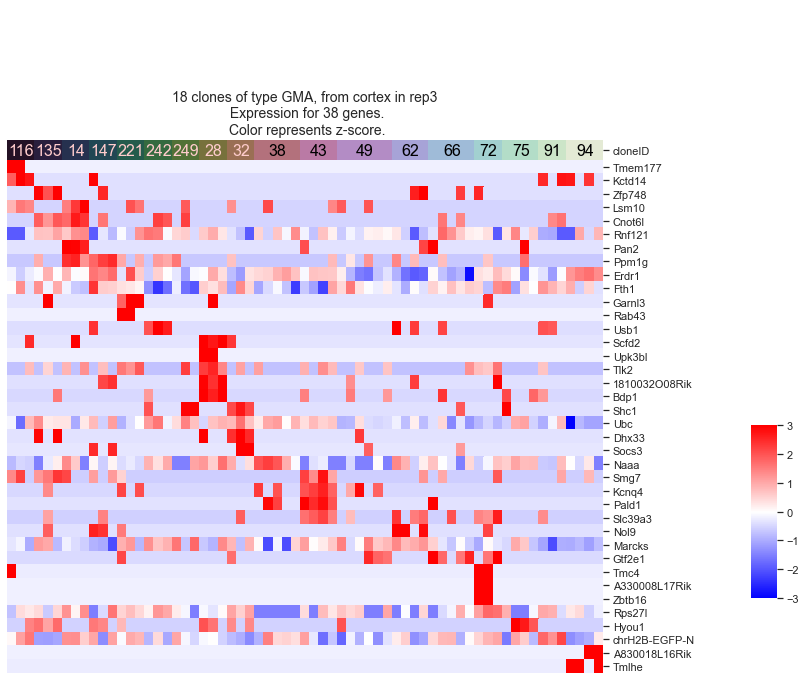

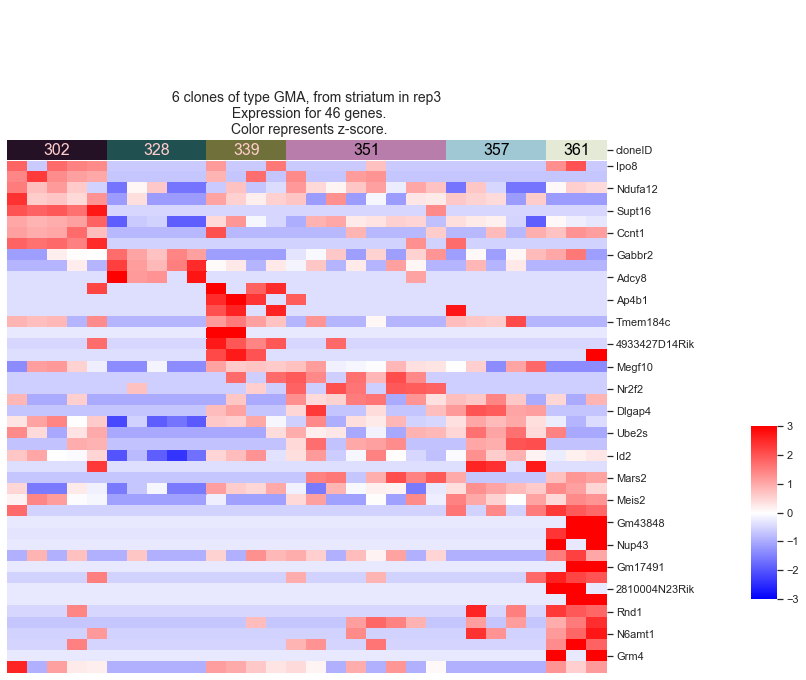

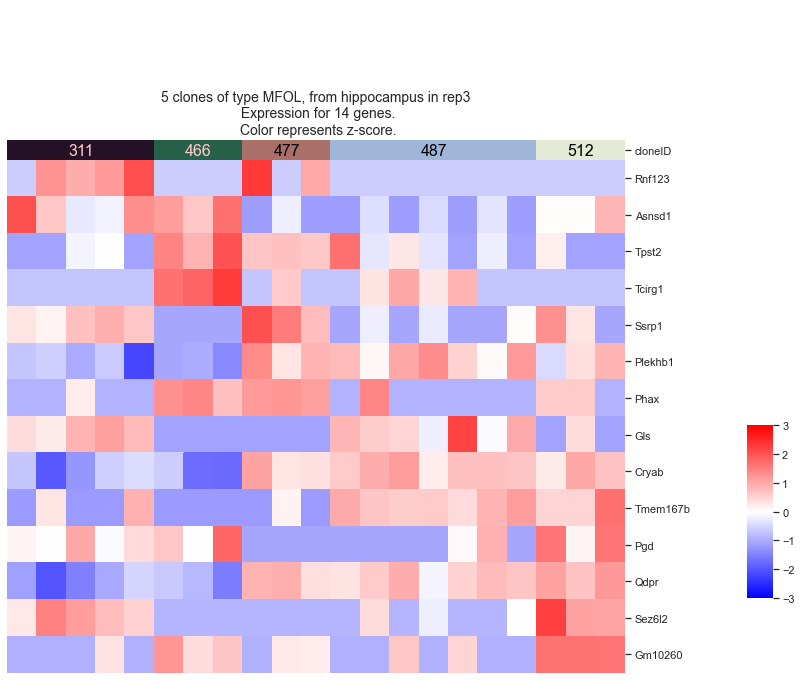

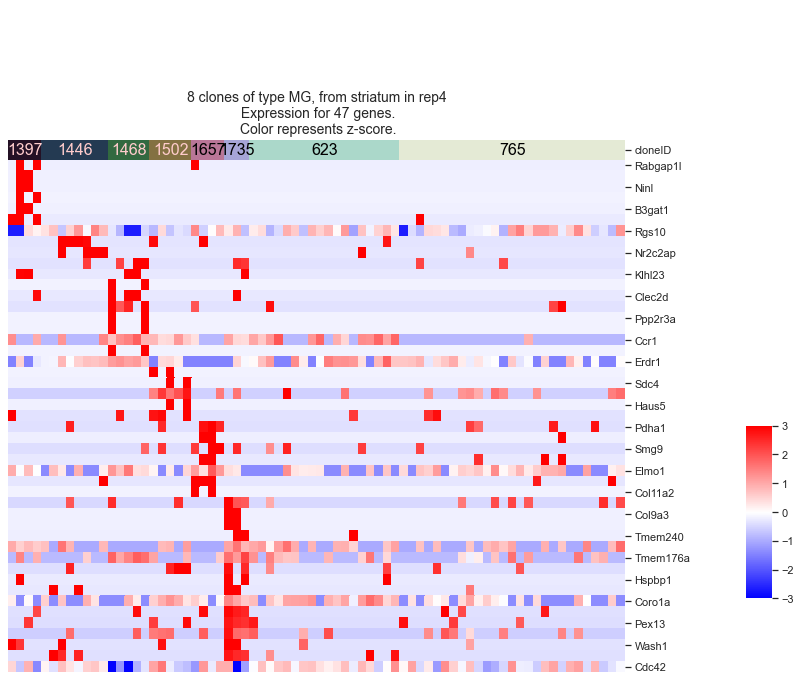

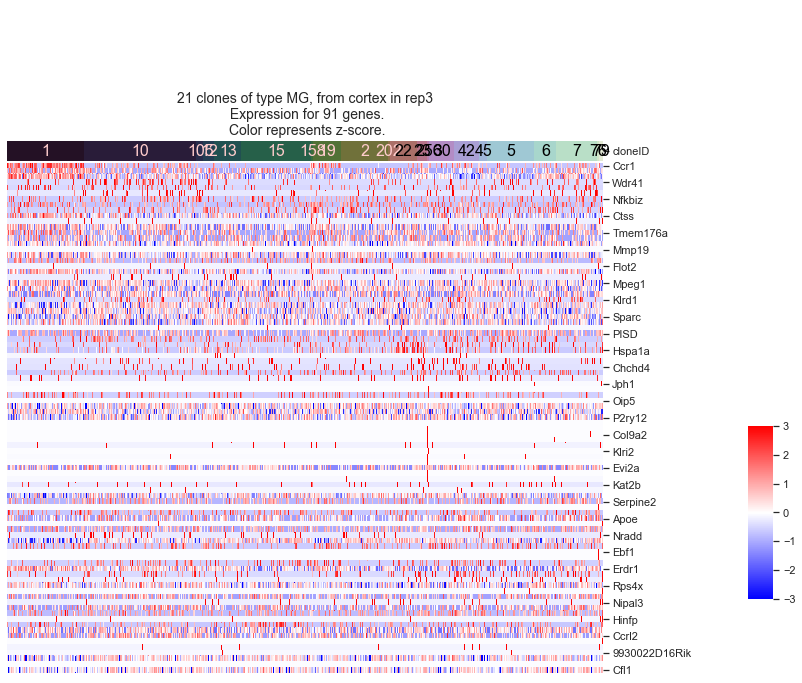

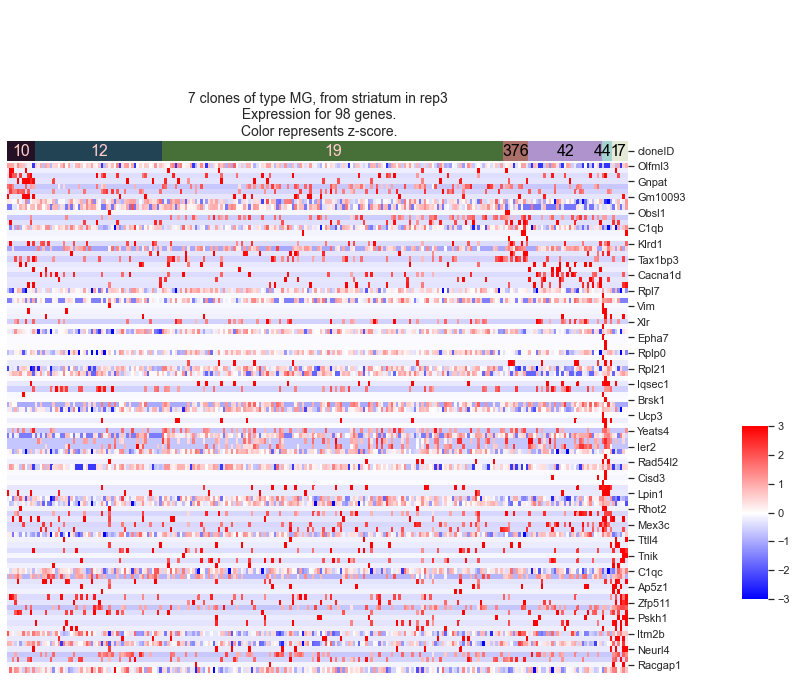

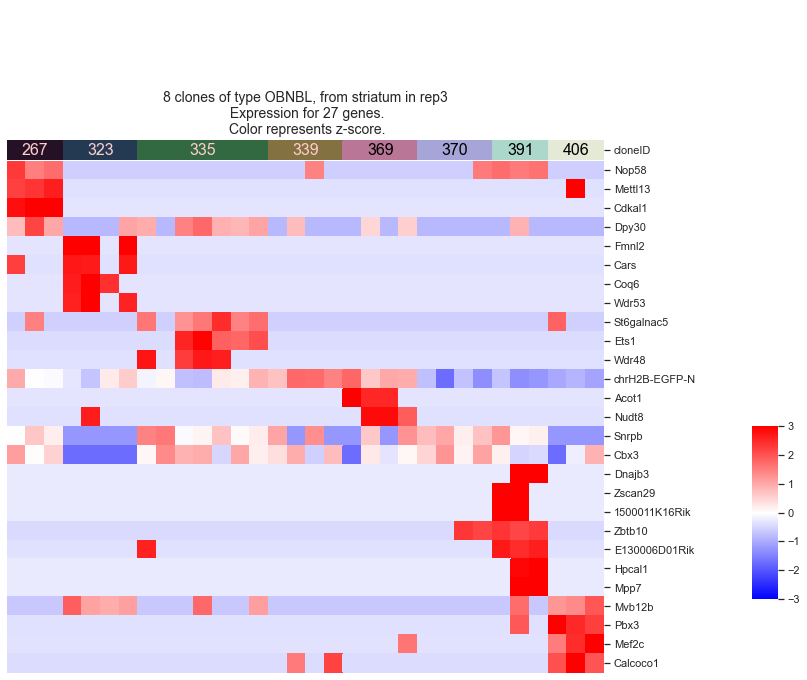

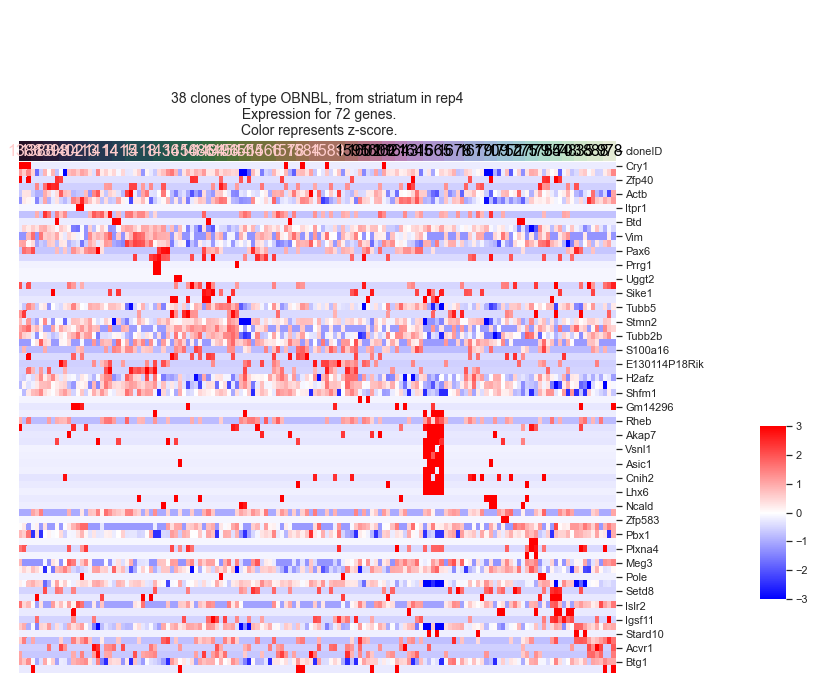

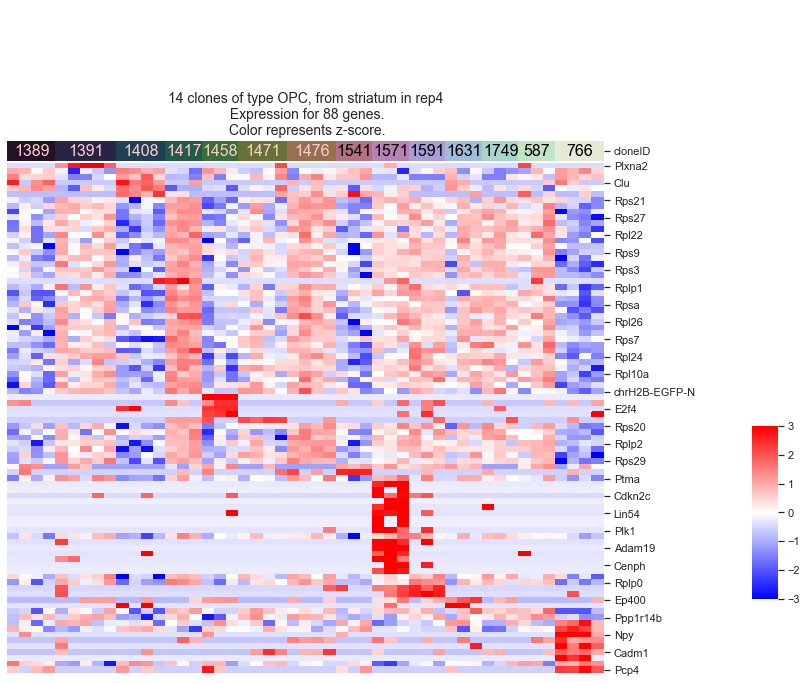

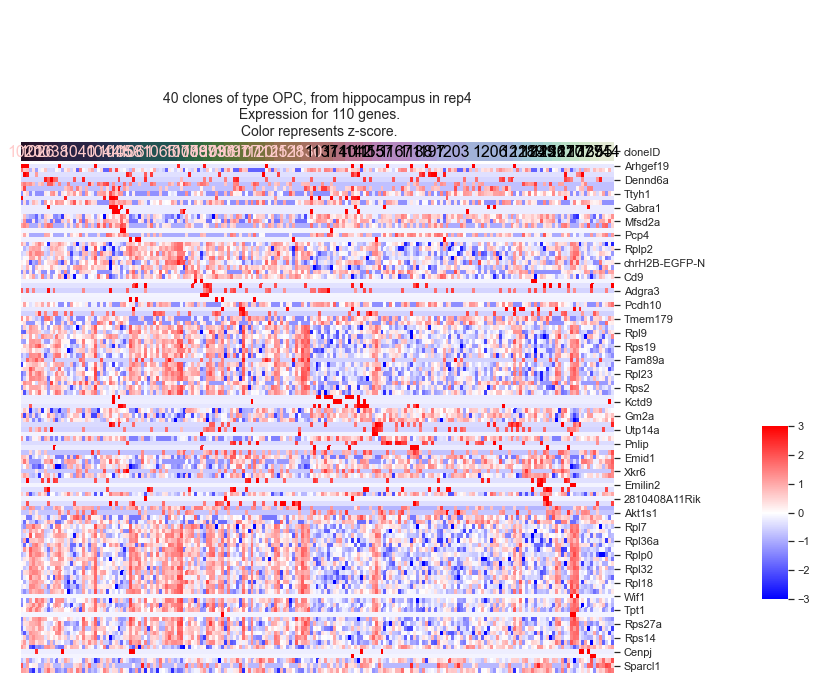

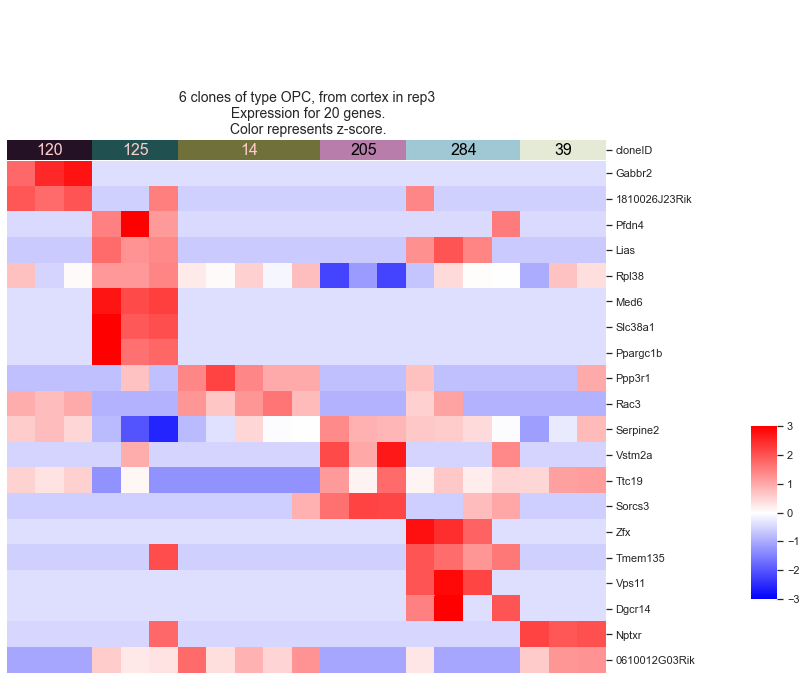

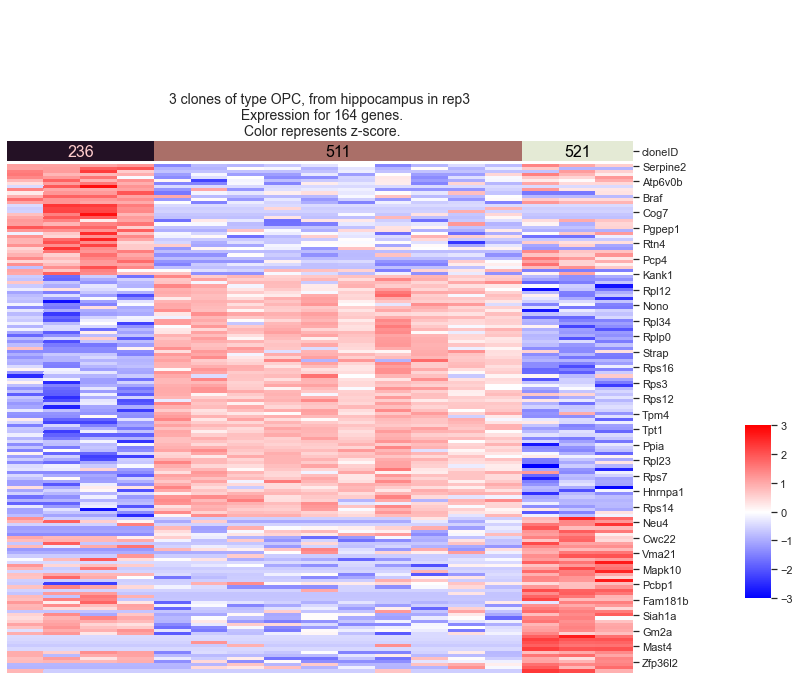

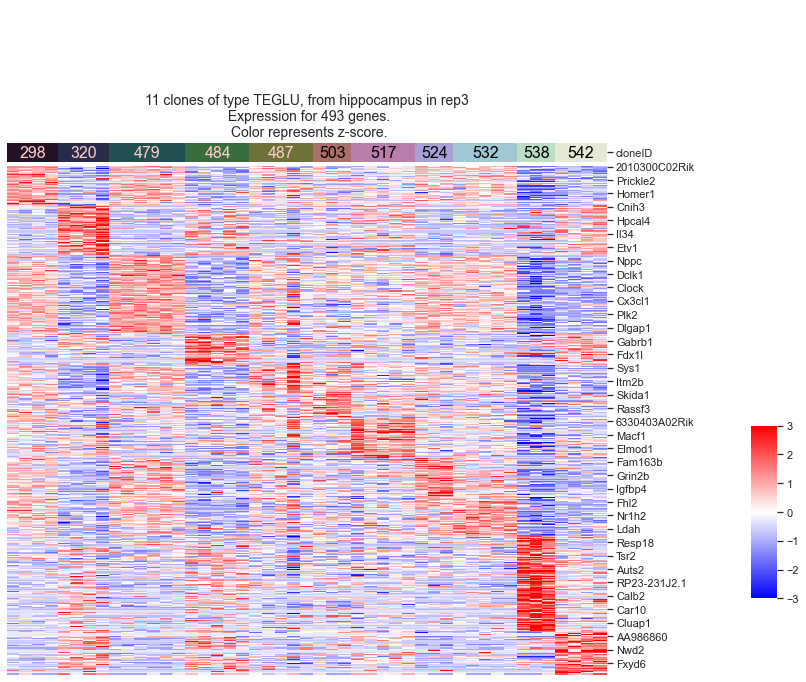

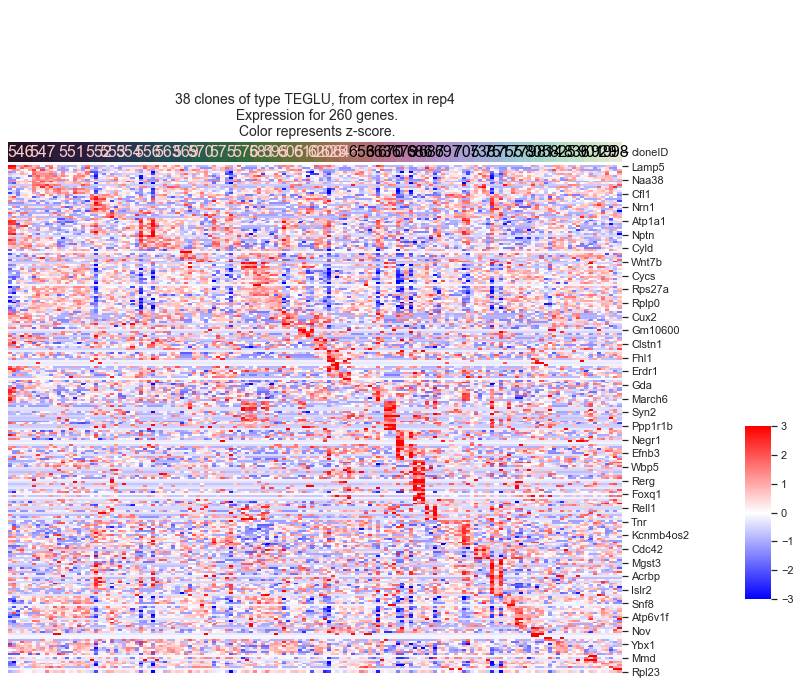

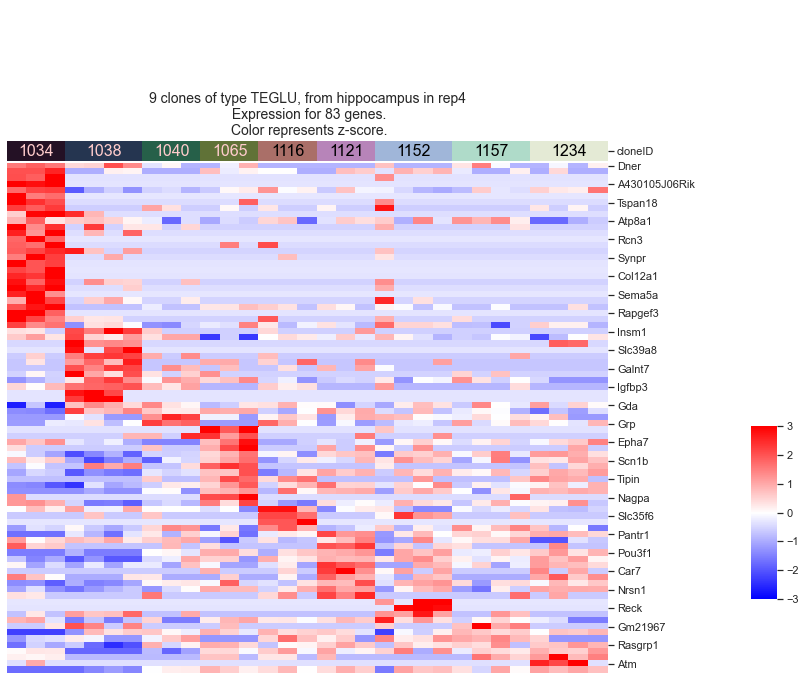

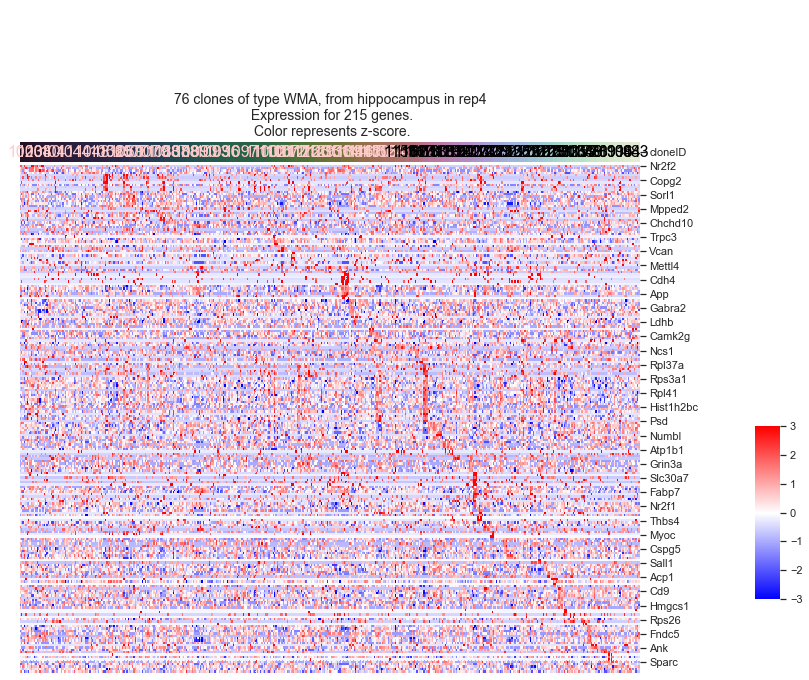

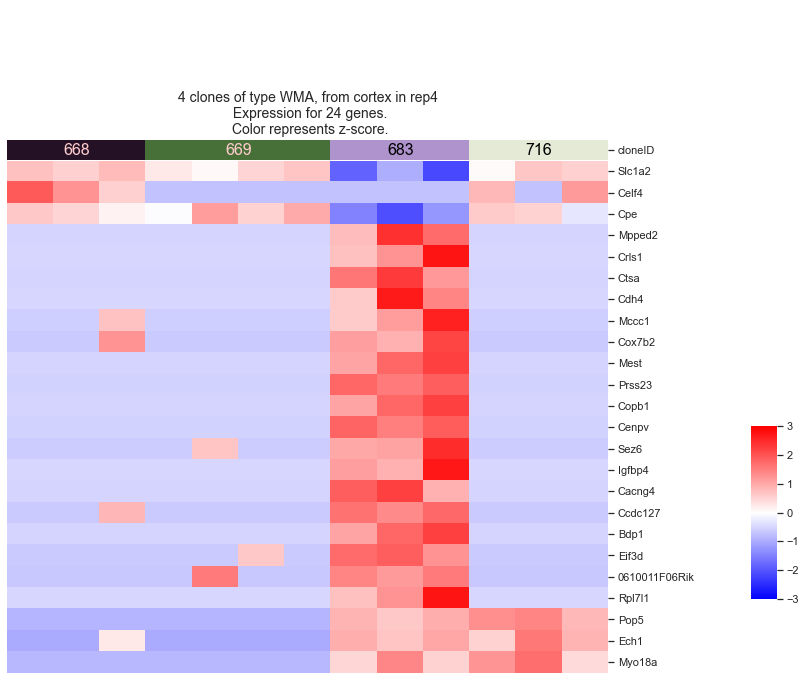

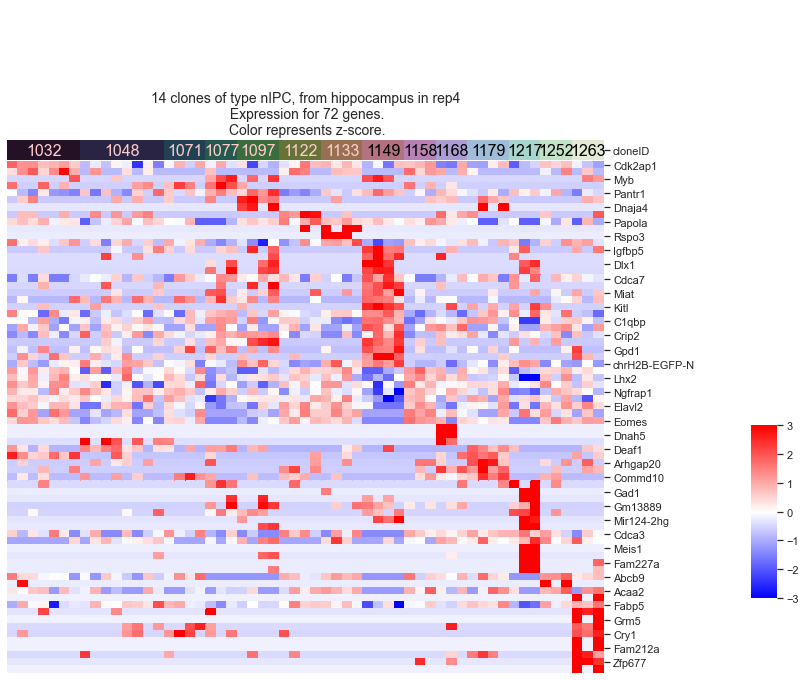

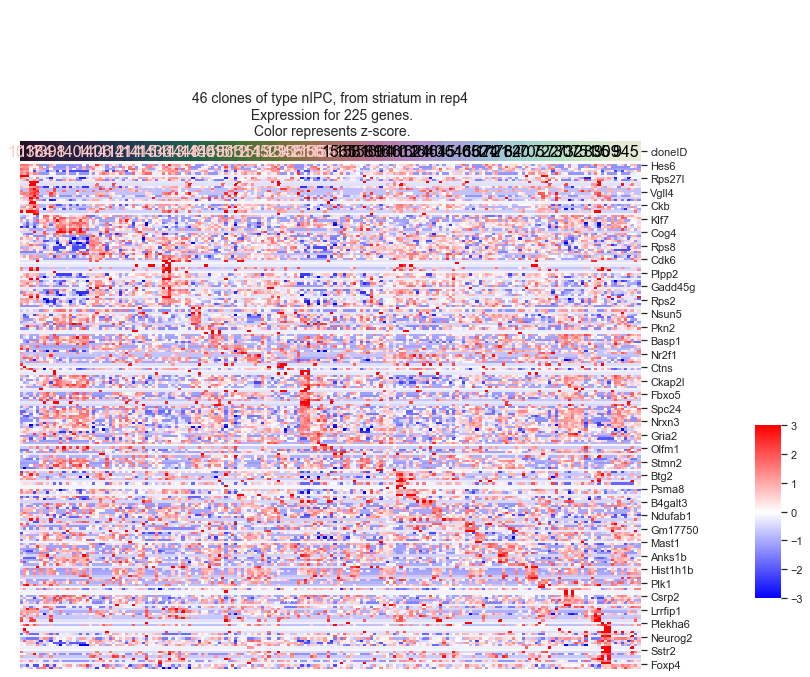

In [89]:
cgds = list(clone_gene_df.index)
for cgd in cgds:
    cgd_info = clone_gene_df.loc[cgd]
    cell_list = get_cells(meta_df, {'region':cgd_info.Region, 
                                    'replicate':cgd_info.Brain,
                                    'cell_type':cgd_info.Cell_type}, 
                          'cloneID')
    genelist = cgd_info.Genes
    vis_genebars(data_df.loc[cell_list], meta_df.loc[cell_list], genelist, 'cloneID', 
                 gene_cluster=False, gene_marker=True,
                 titleline = '{} clones of type {}, from {} in {}'.format(int(cgd_info.Number_of_clones),
                                                                          cgd_info.Cell_type,
                                                                          cgd_info.Region,
                                                                          cgd_info.Brain), savefig='./visMB/'+cgd)

## Odds and ends

We quickly check out a few things.  First -- do clonal genes *within* a cell type also distinguish the clone in other cell types?  E.g., clones 511 and 236 and 521 occur in type OPC, but also in other types.  Do the clonal genes identified in type OPC distinguish the clones in other types?

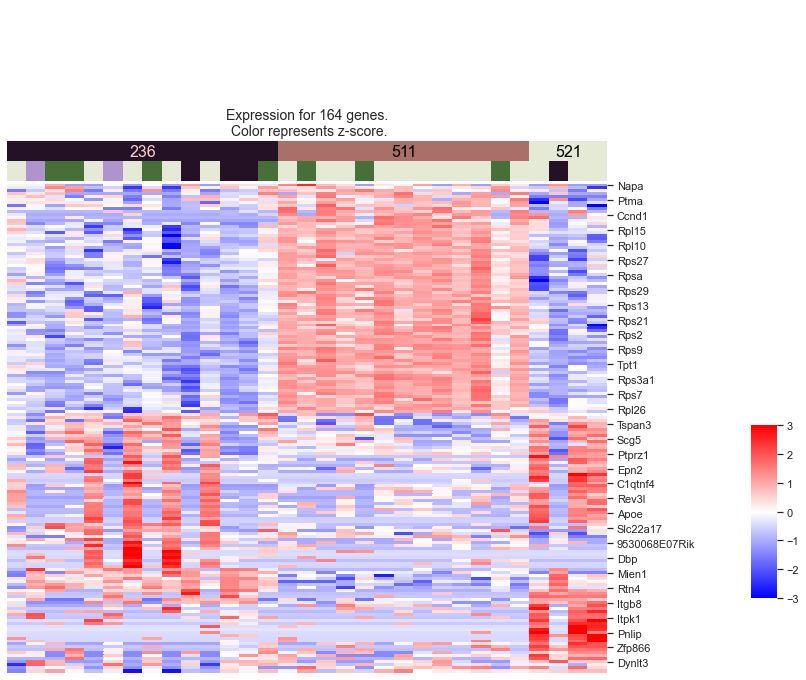

In [92]:
cell_list = meta_df[(meta_df['cloneID'] == '521') | (meta_df['cloneID'] == '511') | (meta_df['cloneID'] == '236')].index
genelist = clone_gene_df.loc['hippocampus_rep3_OPC', 'Genes']

vis_genebars(data_df.loc[cell_list], meta_df.loc[cell_list], genelist, 'cloneID', 
             prop_sec = 'cell_type', titleline='',style='z_score')



The answer seems to be that the RPL/RPS genes distinguish Clone 511 in all cell types.  But the "marker genes" for clones 236 and 521 fail outside of OPC type cells.

Next we look at overlapping gene lists.

In [102]:
from matplotlib_venn import venn3, venn3_circles

['striatum_rep4_OPC', 'hippocampus_rep4_OPC', 'cortex_rep3_OPC', 'hippocampus_rep3_OPC']


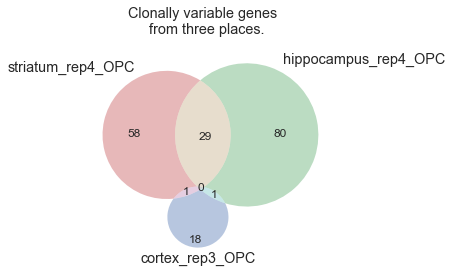

In [103]:
cgdlist = [cgd for cgd in clone_gene_df.index if cgd[-3:] == 'OPC']
print(cgdlist)
geneset_lists = [set(clone_gene_df.loc[cgd,'Genes']) for cgd in cgdlist]
v = venn3(geneset_lists[:3])
v.get_label_by_id('A').set_text(cgdlist[0])
v.get_label_by_id('B').set_text(cgdlist[1])
v.get_label_by_id('C').set_text(cgdlist[2])

plt.suptitle('Clonally variable genes \n from three places.',y=1.02)
plt.show()

There are definitely some overlaps in the clonally significant genes, between the different OPC populations.  Let's look at the 29-gene intersection more closely.  

In [111]:
print(geneset_lists[0] & geneset_lists[1])

{'Rpl23', 'Tpt1', 'Rps19', 'Rpl18a', 'Rps27a', 'Rps7', 'Rps9', 'Rpl10a', 'Rps2', 'Rpl22', 'Pcp4', 'Apoe', 'Rps8', 'Rps3a1', 'Ppp1r14b', 'chrH2B-EGFP-N', 'Rps16', 'Rps3', 'Rplp0', 'Rpsa', 'Rpl41', 'Rps10', 'Rps4x', 'Rplp2', 'Rpl27a', 'Rpl6', 'Ptn', 'Eef1a1', 'Rpl21'}


These are mostly the RPS/RPL genes that seem to play a peculiar role in this whole story.

# Marker genes a la Seurat

Here we imitate Seurat's "find_all_markers" function to find marker genes for each clone.  It turns out to be a bit dangerous -- we'll see evidence of overfitting if this isn't used with caution.

In [112]:
def find_all_markers(X, y, min_pct = 0.1, logfc_threshold = 0.25, only_pos = True, return_thresh=0.01):
    '''
    Mimics Seurat to find all gene expression markers.
    data should contain expression matrix, log1p-normalized.
    meta should be indexed by a subset of data, and contain just the group names for each cell.
    '''
    data = X.reindex(y.index)
    genes = data.columns
    if min_pct:
        gene_totals = (X > 0.0).sum()
        is_good = (gene_totals > (min_pct * len(X)))
        good_genes = is_good[is_good].index
        data = data[good_genes]       
    groups = y.unique()
    mww = pd.DataFrame(index=good_genes, columns=groups) #Mann-Whitney-Wilcoxon
    for group in groups:
        in_group = (y == group) # True for group, False outside of group.
        outof_group = ~in_group
        if logfc_threshold:
            X_means = data.groupby(in_group).mean()
            is_good = (X_means.loc[True] - X_means.loc[False]) >= logfc_threshold
            if only_pos == False:
                is_good = is_good | (X_means.loc[False] - X_means.loc[True]) >= logfc_threshold
            good_genes = is_good[is_good].index
        print('Looking at {} genes for clone {}'.format(len(good_genes), group))
        mww[group] = pd.Series({gene : ss.mannwhitneyu(data[in_group][gene], data[outof_group][gene]).pvalue 
                                  for gene in good_genes})
    return mww

Now we find the marker genes for all clones (with at least 5 cells) within type GMA.  Our implementation is not terribly fast.

In [116]:
bigGMA = (meta_df[meta_df['cell_type'] == 'GMA'].cloneID.value_counts() >=5 )
bigGMA = bigGMA[bigGMA].index
test_cells = meta_df[(meta_df['cell_type'] == 'GMA') & meta_df['cloneID'].isin(bigGMA)]
mww = find_all_markers(data_df, test_cells.cloneID)

Looking at 1050 genes for clone 66
Looking at 1005 genes for clone 49
Looking at 1139 genes for clone 38
Looking at 864 genes for clone 328
Looking at 1087 genes for clone 357
Looking at 731 genes for clone 351
Looking at 1094 genes for clone 302
Looking at 1076 genes for clone 487
Looking at 943 genes for clone 483
Looking at 335 genes for clone 1038
Looking at 678 genes for clone 1155
Looking at 1223 genes for clone 1120
Looking at 906 genes for clone 1020
Looking at 1053 genes for clone 1040
Looking at 1088 genes for clone 800
Looking at 1214 genes for clone 1400
Looking at 1003 genes for clone 1423
Looking at 292 genes for clone 1516


We shuffle clone labels for a permutation test, and find the marker genes for these fake clones.

In [117]:
tcc = test_cells.cloneID.copy()
np.random.shuffle(tcc.values)
mww_shuff = find_all_markers(data_df, tcc)

Looking at 971 genes for clone 1120
Looking at 1069 genes for clone 487
Looking at 992 genes for clone 1400
Looking at 1072 genes for clone 66
Looking at 632 genes for clone 351
Looking at 735 genes for clone 1020
Looking at 1016 genes for clone 302
Looking at 641 genes for clone 1155
Looking at 991 genes for clone 1040
Looking at 181 genes for clone 1038
Looking at 812 genes for clone 49
Looking at 1001 genes for clone 328
Looking at 999 genes for clone 800
Looking at 145 genes for clone 1516
Looking at 921 genes for clone 1423
Looking at 1075 genes for clone 357
Looking at 895 genes for clone 483
Looking at 1098 genes for clone 38


Now we create a heatmap of the GMA cells and the marker genes we have found. Looks pretty good.

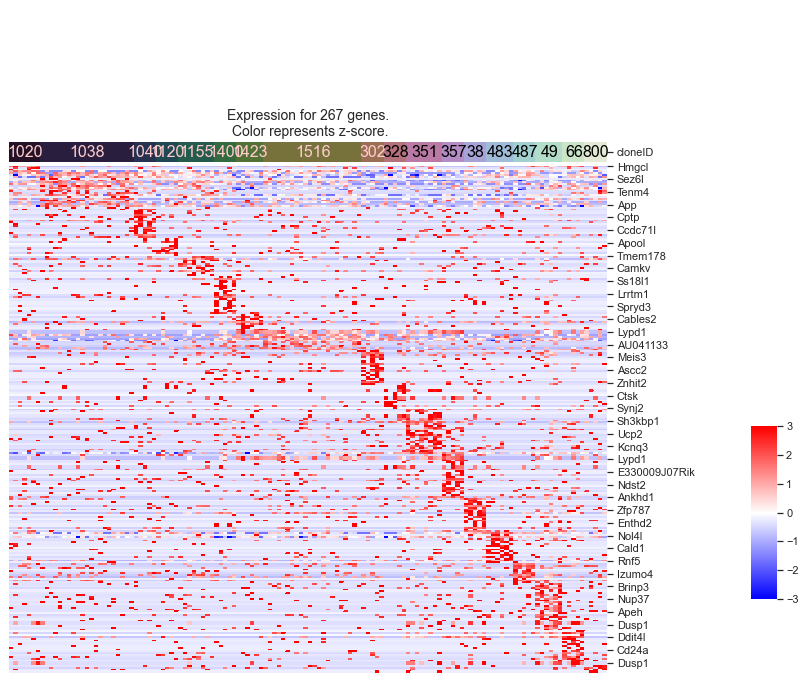

In [118]:
marker_genes = []
mww_clones = list(mww.columns)
mww_clones.sort()
mww_clones
for col in mww_clones:
    col_markers = list(mww[col][mww[col]<0.0001].index)
    marker_genes += col_markers
vis_genebars(data_df.loc[test_cells.index], meta_df.loc[test_cells.index], marker_genes, 'cloneID', 
             style='z_score', titleline='', gene_cluster=False)

Now we do the same thing, but using our marker genes for fake clones.

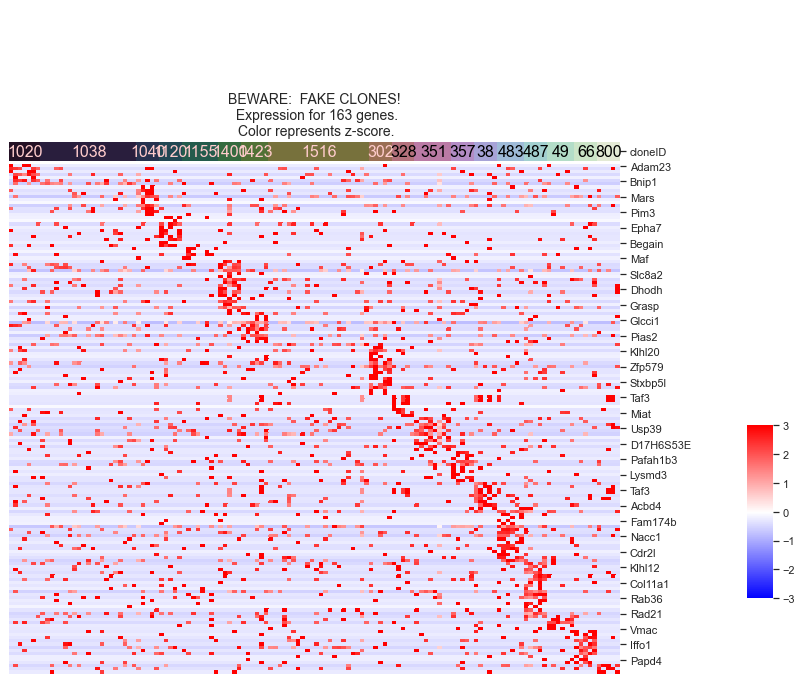

In [121]:
marker_genes_shuff = []
mww_clones = list(mww_shuff.columns)
mww_clones.sort()
mww_clones
for col in mww_clones:
    col_markers = list(mww_shuff[col][mww_shuff[col]<0.0001].index)
    marker_genes_shuff += col_markers
vis_genebars(data_df.loc[test_cells.index], tcc, marker_genes_shuff, 'cloneID', 
             style='z_score', titleline='BEWARE:  FAKE CLONES!', gene_cluster=False)

We have certainly found *fewer* marker genes, indicating a clonal significance beyond what's found by chance.  But the heatmap shows that overfitting is a danger.  One should not give too much significance to the original marker gene heatmap since one can get a very pretty-looking heatmap using fake clones.  Here is a more dramatic example, by loosening the p-value cutoff a bit.

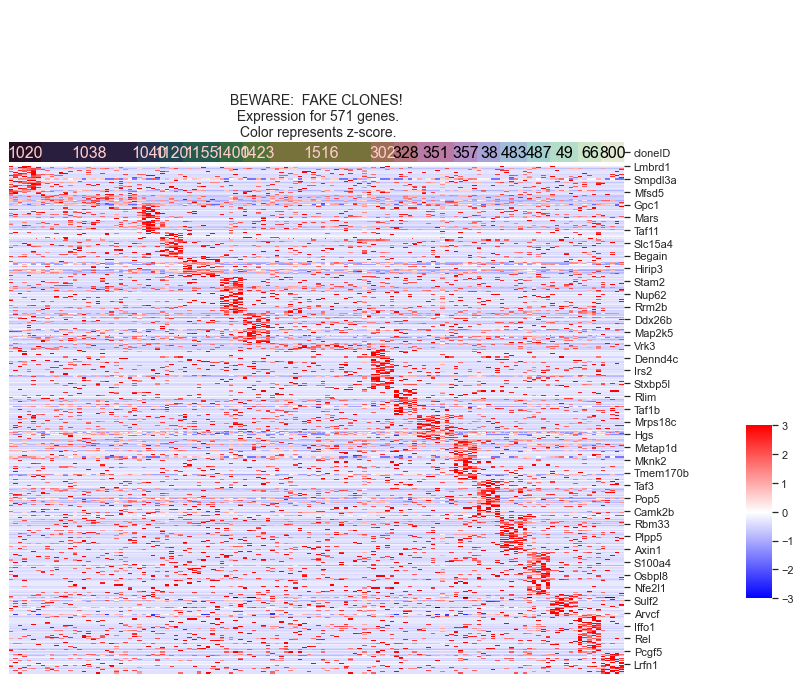

In [122]:
marker_genes_shuff = []
mww_clones = list(mww_shuff.columns)
mww_clones.sort()
mww_clones
for col in mww_clones:
    col_markers = list(mww_shuff[col][mww_shuff[col]<0.001].index)
    marker_genes_shuff += col_markers
vis_genebars(data_df.loc[test_cells.index], tcc, marker_genes_shuff, 'cloneID', 
             style='z_score', titleline='BEWARE:  FAKE CLONES!', gene_cluster=False)

# Clustering within cell types, by clonality.

Out of curiosity, let's try some clustering based on clonally significant genes.  Maybe TEGLU is interesting, and we'll be able to see cell subtypes.

In [158]:
clone_gene_df.loc['hippocampus_rep3_TEGLU']

Region                                                    hippocampus
Brain                                                            rep3
Cell_type                                                       TEGLU
Genes               [Xkr4, Rpl7, Plekhb2, 2010300C02Rik, Gm16152, ...
Number_of_clones                                                   11
Name: hippocampus_rep3_TEGLU, dtype: object

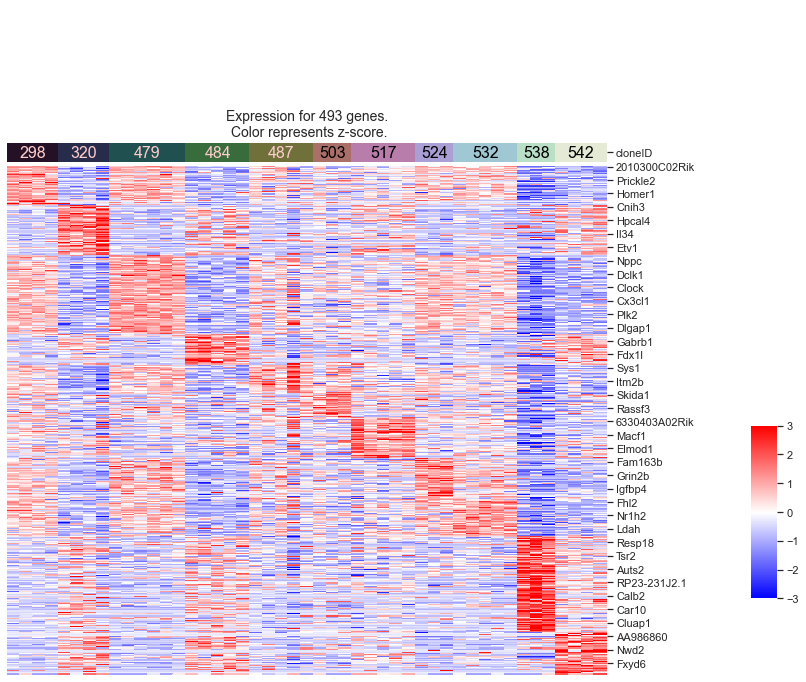

In [159]:
cell_list = get_cells(meta_df, {'region':'hippocampus', 'replicate':'rep3', 'cell_type':'TEGLU'}, 'cloneID')
genelist = clone_gene_df.loc['hippocampus_rep3_TEGLU', 'Genes']

vis_genebars(data_df.loc[cell_list], meta_df.loc[cell_list], genelist, 'cloneID', gene_cluster=False, gene_marker=True,
             titleline='',style='z_score')


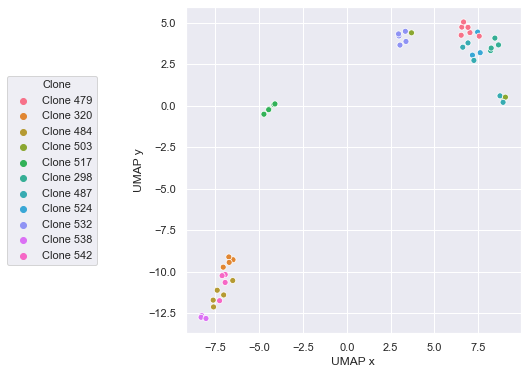

In [160]:
from sklearn.decomposition import PCA
import umap

n_components = 10
n_neighbors = 6
min_dist = 0.25
fig, ax = plt.subplots(figsize=(6,6))

X = data_df.loc[cell_list]
y = meta_df.loc[cell_list].cloneID
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X[genelist]) # Apply PCA with 10 components.
X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                       random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
cl_df['Clone'] = ['Clone '+cl for cl in y.values]
g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', data = cl_df, ax=ax)
g.legend(loc='center left', bbox_to_anchor=(-0.55, 0.5), ncol=1)
plt.show()

Let's take that same batch of 493 genes, and use them to cluster *all* TEGLU cells, not just those from hippocampus and rep3.

In [165]:
cell_list = get_cells(meta_df, {'cell_type':'TEGLU'}, 'cloneID')
genelist = clone_gene_df.loc['hippocampus_rep3_TEGLU', 'Genes']

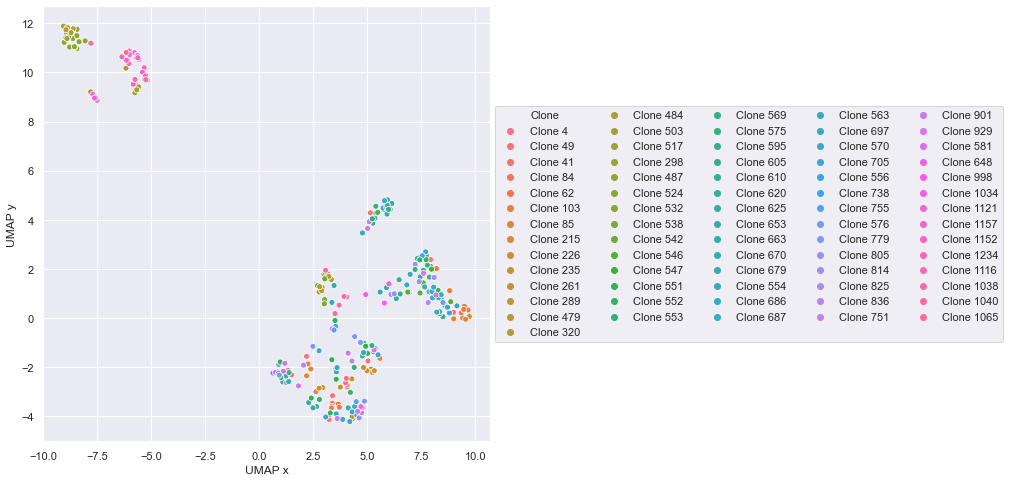

In [168]:
from sklearn.decomposition import PCA
import umap

n_components = 10
n_neighbors = 30
min_dist = 0.25
fig, ax = plt.subplots(figsize=(8,8))

X = data_df.loc[cell_list]
y = meta_df.loc[cell_list].cloneID
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X[genelist]) # Apply PCA with 10 components.
X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                       random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
cl_df['Clone'] = ['Clone '+cl for cl in y.values]
g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', data = cl_df, ax=ax)
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=5)
plt.show()

There seem to be two robust clusters (top-left and bottom-right) subdivided into multiple, less robust subclusters.  By robustness, I mean that they hold up under change of parameters like number of neighbors used in UMAP clustering.  I suppose that TEGLU should really represent two (or more?) cell subtypes.

We carry out a similar analysis of OPC cells.  We begin with a specific region and replicate, where the heatmap looked very clean.

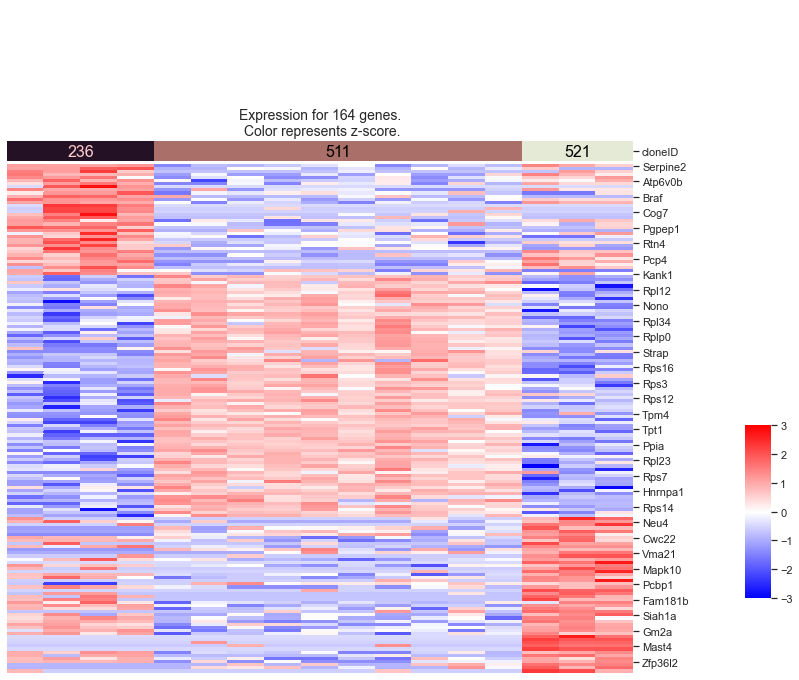

In [176]:
cell_list = get_cells(meta_df, {'region':'hippocampus', 'replicate':'rep3', 'cell_type':'OPC'}, 'cloneID')
genelist = clone_gene_df.loc['hippocampus_rep3_OPC', 'Genes']

vis_genebars(data_df.loc[cell_list], meta_df.loc[cell_list], genelist, 'cloneID', gene_cluster=False, gene_marker=True,
             titleline='',style='z_score')

If we use these genes to cluster, we should certainly see Clone 511 far from the other two clones, and maybe some separation between 236 and 521 too.

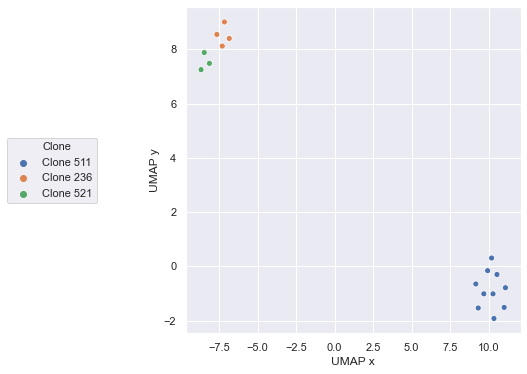

In [181]:
from sklearn.decomposition import PCA
import umap

n_components = 10
n_neighbors = 5
min_dist = 0.25
fig, ax = plt.subplots(figsize=(6,6))

X = data_df.loc[cell_list]
y = meta_df.loc[cell_list].cloneID
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X[genelist]) # Apply PCA with 10 components.
X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                       random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
cl_df['Clone'] = ['Clone '+cl for cl in y.values]
g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', data = cl_df, ax=ax)
g.legend(loc='center left', bbox_to_anchor=(-0.55, 0.5), ncol=1)
plt.show()

Indeed, the clustering separates 511 from the other two clones, and the other two clones are slightly separate from each other.  In fact, if we dial "number of neighbors" down to 3, the clones 521 and 236 pull apart.

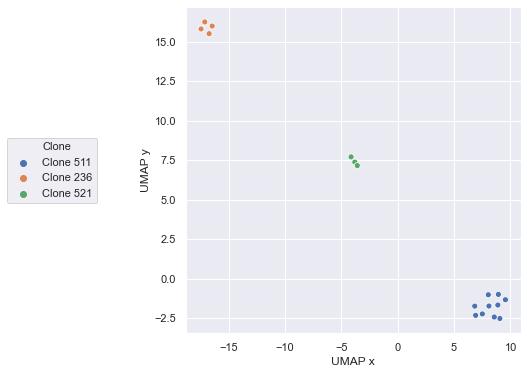

In [183]:
from sklearn.decomposition import PCA
import umap

n_components = 10
n_neighbors = 3
min_dist = 0.25
fig, ax = plt.subplots(figsize=(6,6))

X = data_df.loc[cell_list]
y = meta_df.loc[cell_list].cloneID
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X[genelist]) # Apply PCA with 10 components.
X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                       random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
cl_df['Clone'] = ['Clone '+cl for cl in y.values]
g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', data = cl_df, ax=ax)
g.legend(loc='center left', bbox_to_anchor=(-0.55, 0.5), ncol=1)
plt.show()

Now we use the same set of 164 genes to cluster OPC cells from all regions and replicates.

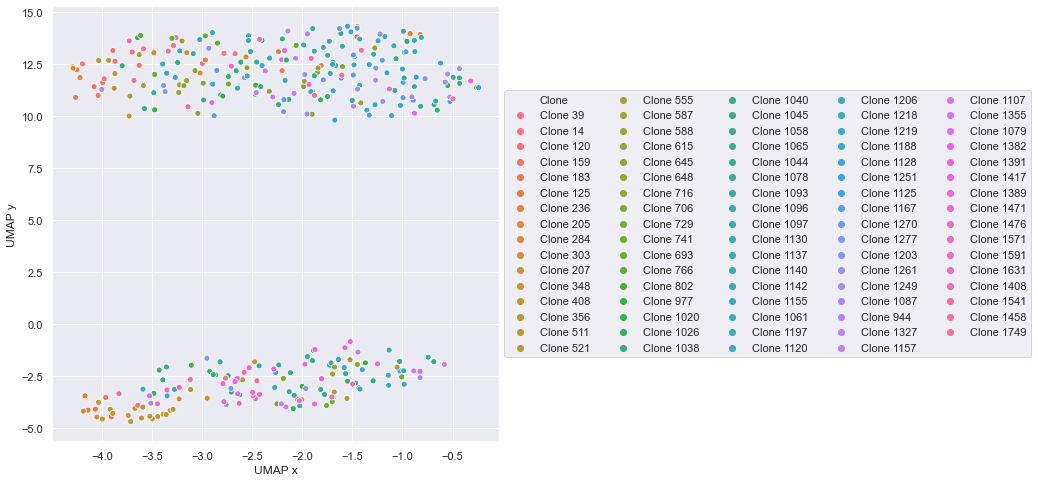

In [186]:
cell_list = get_cells(meta_df, {'cell_type':'OPC'}, 'cloneID')
genelist = clone_gene_df.loc['hippocampus_rep3_OPC', 'Genes']

n_components = 10
n_neighbors = 30
min_dist = 0.25
fig, ax = plt.subplots(figsize=(8,8))

X = data_df.loc[cell_list]
y = meta_df.loc[cell_list].cloneID
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X[genelist]) # Apply PCA with 10 components.
X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                       random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
cl_df['Clone'] = ['Clone '+cl for cl in y.values]
g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', data = cl_df, ax=ax)
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=5)
plt.show()


There's an obvious division into two groups, presumably from the RPS/RPL genes.  If we dial down n_neighbors to 5 (roughly the size of a clone), we still see two groups, and maybe (?!) some smaller clusters forming.

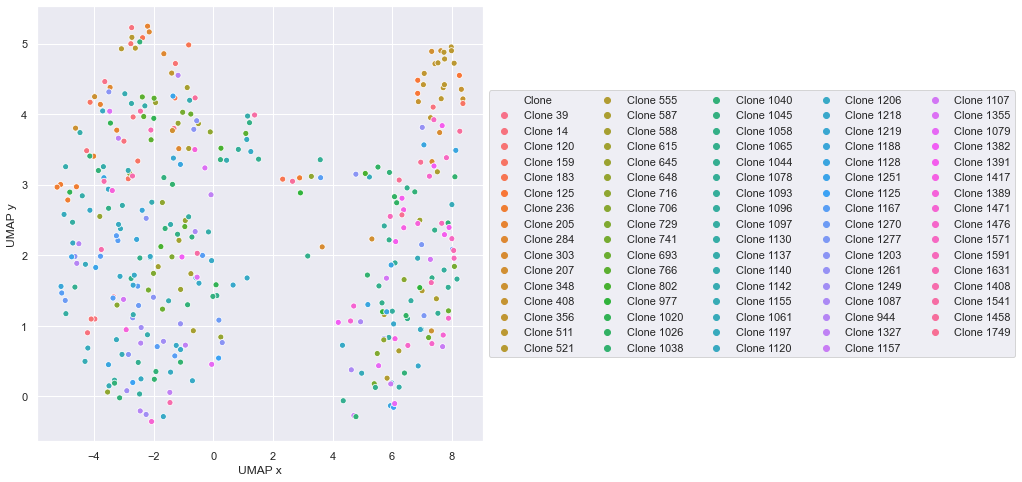

In [188]:
cell_list = get_cells(meta_df, {'cell_type':'OPC'}, 'cloneID')
genelist = clone_gene_df.loc['hippocampus_rep3_OPC', 'Genes']

n_components = 10
n_neighbors = 5
min_dist = 0.25
fig, ax = plt.subplots(figsize=(8,8))

X = data_df.loc[cell_list]
y = meta_df.loc[cell_list].cloneID
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X[genelist]) # Apply PCA with 10 components.
X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                       random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
cl_df['Clone'] = ['Clone '+cl for cl in y.values]
g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', data = cl_df, ax=ax)
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=5)
plt.show()